<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 13th Jan, 2024
# Click through rate prediction
#  Predict whether a mobile ad will be clicked
# Data Source:
#   https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

In case you are not executing the code, but only giving it a reading to understand it, please open it in colab to take adavantage of proper manageable collapsible, hierarchical structure of notebook.

## Cleanup
Delete all earlier saved work. Start afresh. Commented to avoid deleteion by mistake.

In [ ]:
# -0.2 WARN Will delete all earlier work

#   Delete all saved avazu data

"""
from pathlib import Path
import shutil
avazufolder = Path("C:\\avazu\\allmodels\\")

if avazufolder.exists():
    shutil.rmtree(avazufolder)
"""

## Basics
Package installations, calling libraries and creating folders to save work

In [ ]:
# 0.1 Install from pypi:
%reset
!pip install catencfamily==0.0.96  # 0.0.99 next

In [ ]:
# 0.2 Easy to format columns into tables:
#     Used pandas also

! pip install python-tabulate

ERROR: Could not find a version that satisfies the requirement python-tabulate (from versions: none)
ERROR: No matching distribution found for python-tabulate


In [ ]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time


# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,f1_score,roc_auc_score,accuracy_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0.4
import xgboost as xgb
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
from tabulate import tabulate
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'karateclub', 'leidenalg', 'graph_tool', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [ ]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Create folders to save our work
We save data and results so that next time, work can continue from that point onwards.

In [ ]:
# 1.0.7 Our folders to save work and results:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [ ]:
# 1.0.7 Our folders (alternative place):
#       You can substitute below with your
#         own alternative place (for example colab
#           VM foders such as /content/) BUT do not
#             change folder names as these are used
#              throughout the code.

avazufolder = Path("c:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..
avazuunitvecs = avazufolder / "unitvectors"   # For unitvectors

In [ ]:
# 1.0.8 Create all these folders, if not already existing:

avazufolder.mkdir(parents=True, exist_ok=True)
avazugraphs.mkdir(parents=True, exist_ok=True)
avazudata.mkdir(parents=True, exist_ok=True)
avazuestimators.mkdir(parents=True, exist_ok=True)
avazuunitvecs.mkdir(parents=True, exist_ok=True)


In [ ]:
# 1.0.9 Decide program-wide random state:
#       Yes, if we discontinue in between
#       and restart from some other point
#       in the notebook, this would change.

rng= np.random.RandomState(None)

## Taking a sample of data
We take a sample of 20lakh observations (limited by RAM that we have)


In [ ]:
## 1.1 We will extract data randomly from disk using the following code:

dataPath = "c:\\avazu\\"

dtypes = {
        'C1'              : 'uint16',
        'banner_pos'      : 'uint8',
        'device_type'     : 'uint8',
        'device_conn_type': 'uint8',
        'C14'             : 'uint16',
        'C15'             : 'uint16',
        'C16'             : 'uint16',
        'C17'             : 'uint16',
        'C18'             : 'uint8',
        'C19'             : 'uint16',
        'C20'             : 'int32',
        'click'           : 'uint8'
        }

print('load train...')


# 1.2 Read a fraction of data
total_lines = 40428967   #  (40428967, 24)
read_lines =   2000000

# 1.3 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
train = pd.read_csv(
                     dataPath + "train.gz",
                     header=0,
                     skiprows=lambda i: (i >0 ) and (np.random.random() > p),
                     dtype=dtypes,
                     parse_dates=['hour'],
                     date_parser=parse_date
                    )   # Takes 2minutes

_= gc.collect()

load train...


In [ ]:
# 1.3.1
train.shape   # (2001493, 24)/(1998733, 24)/(1999324, 24)/(1999503, 24)/(2001360, 24)
train.head(3)

(1999598, 24)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10006415976094813740,0,2014-10-21,1005,0,f84e52b6,d7e2f29b,28905ebd,ecad2386,7801e8d9,...,1,0,16838,320,50,1882,3,35,-1,13
1,10006958186789044052,1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,1,0,18993,320,50,2161,0,35,100034,157
2,10010452321736390000,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,100084,79


In [ ]:
# 1.3.2 Imbalanced data:

train['click'].value_counts()
print("\n")
train['click'].value_counts(normalize = True)  # 83%:17%

# 1.3.3
train.dtypes

0    1659222
1     340376
Name: click, dtype: int64

0    0.829778
1    0.170222
Name: click, dtype: float64

In [ ]:
# 1.3.4 Separate target, and drop id

y = train.pop("click")
_= train.pop("id")

## Prepare data for transformation
Check cat cols, column names, null values and label-encode, if neeeded

In [ ]:
# 1.3.5 Our list of columns:

print(list(train.columns))

# 1.1.6 Here is a list of all columns except 'hour'
cols = ["C1","banner_pos","site_id","site_domain","site_category",
        "app_id","app_domain","app_category","device_id","device_ip",
        "device_model", "device_type", "device_conn_type", "C14",
        "C15", "C16","C17", "C18", "C19", "C20", "C21"]

['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [ ]:
# 2.0 Check no of unique values in every column
#     Two columns, device_id and device_ip,
#     have very large no of unique values:

u = []
for i in train.columns:
  u.append([i, train[i].nunique()])

# 3.1.1
print(tabulate(u, headers = ["col name", "No of unique values"]))

col name            No of unique values
----------------  ---------------------
hour                                240
C1                                    7
banner_pos                            7
site_id                            3029
site_domain                        3512
site_category                        23
app_id                             3962
app_domain                          241
app_category                         28
device_id                        278842
device_ip                        963159
device_model                       5757
device_type                           5
device_conn_type                      4
C14                                2367
C15                                   8
C16                                   9
C17                                 424
C18                                   4
C19                                  66
C20                                 165
C21                                  60


In [ ]:
# 2.1 Rename columns as per requirement of our CatEncodersFamily class
#     Column names are not to have digits and underscores:

cols = {
        "C1" : "Cone",
        "banner_pos" : "bannerpos",
        "site_id"    :  "siteid",
        "site_domain": "sitedomain",
        "site_category" : "sitecategory",
        "app_id"        : "appid",
        "app_domain"    : "appdomain",
        "app_category"  : "appcategory",
        "device_model"  : "devicemodel",
        "device_type"   : "devicetype",
        "device_ip"     : "deviceip",
        "device_id"      : "deviceid",
        "device_conn_type" : "deviceconntype",
        "C14" : "Cfourteen",
        "C15" : "Cfifteen",
        "C16" : "Csixteen",
        "C17" : "Cseventeen",
        "C18" : "Ceighteen",
        "C19" : "Cnineteen",
        "C20" : "Ctwenty",
        "C21" : "Ctwentyone"
        }

train = train.rename( columns = cols)
train.shape  #    (2001493, 22)/(1998733, 22)/(1999324, 22)/(1999503, 22)
train.head(3)

(1999598, 22)

,hour,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,...,devicetype,deviceconntype,Cfourteen,Cfifteen,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone
0,2014-10-21,1005,0,f84e52b6,d7e2f29b,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,16838,320,50,1882,3,35,-1,13
1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,f95efa07,a99f214a,...,1,0,18993,320,50,2161,0,35,100034,157
2,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,15701,320,50,1722,0,35,100084,79


### Extract date components

In [ ]:
# 2.2 Extract date components then del 'hour' column:

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour

_=train.pop('hour')
train.head(2)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,f84e52b6,d7e2f29b,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a8649089,...,50,1882,3,35,-1,13,10,1,21,0
1,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,f95efa07,a99f214a,ce6e6bbd,...,50,2161,0,35,100034,157,10,1,21,0


### Label Encoding cat cols
xgboost classifier will not accept columns having text data

In [ ]:
# 3.0 Some columns need label encoding for feeding
#     into xgboost classifier. xgboost classifier will
#     not accept columns with text values.

train.iloc[:, :5].head(2)   # siteid, sitedomain,sitecategory
train.iloc[:, 5:10].head(2)   # appid,appdomain,appcategory,device_id,device_ip
train.iloc[:, 10:15].head(2)  # devicemodel


,Cone,bannerpos,siteid,sitedomain,sitecategory
0,1005,0,f84e52b6,d7e2f29b,28905ebd
1,1005,0,85f751fd,c4e18dd6,50e219e0


,appid,appdomain,appcategory,deviceid,deviceip
0,ecad2386,7801e8d9,07d7df22,a99f214a,a8649089
1,0acbeaa3,45a51db4,f95efa07,a99f214a,ce6e6bbd


,devicemodel,devicetype,deviceconntype,Cfourteen,Cfifteen
0,e9b8d8d7,1,0,16838,320
1,2cd8ff6d,1,0,18993,320


In [ ]:
# 3.0.1 List of cols to label encode:

ColumnsToLabelEncode = ["siteid", "sitedomain", "appid", "appdomain",
                        "appcategory", "deviceid", "deviceip",
                        "devicemodel", 'sitecategory']


# 3.0.2 Check our list once again:

train[ColumnsToLabelEncode[:4]].head(2)
train[ColumnsToLabelEncode[4:]].head(2)


,siteid,sitedomain,appid,appdomain
0,f84e52b6,d7e2f29b,ecad2386,7801e8d9
1,85f751fd,c4e18dd6,0acbeaa3,45a51db4


,appcategory,deviceid,deviceip,devicemodel,sitecategory
0,07d7df22,a99f214a,a8649089,e9b8d8d7,28905ebd
1,f95efa07,a99f214a,ce6e6bbd,2cd8ff6d,50e219e0


In [ ]:
# 3.1 Label encode columns of train data:
#     Takes time:

dict_ = {}  # To save label encoder objects here for future use
for i in ColumnsToLabelEncode:
    le = LabelEncoder()
    _=le.fit(train[i])
    train[i] = le.transform(train[i])
    dict_[i] = le  # Store the label encoder object
    _=gc.collect()

In [ ]:
# 3.2 Check again if encoding done?

train[ColumnsToLabelEncode[:4]].head(3)
train[ColumnsToLabelEncode[4:]].head(3)

,siteid,sitedomain,appid,appdomain
0,2923,2983,3667,107
1,1575,2720,169,62
2,359,3339,3667,107


,appcategory,deviceid,deviceip,devicemodel,sitecategory
0,0,184979,633844,5242,1
1,26,184979,776935,959,5
2,0,184979,778570,3615,1


### Partition data

In [ ]:
# 4.0 Split our data

X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    random_state= rng)




# 4.0.1 Check shapes:
X_train.shape    # (1501119, 25)/(1499049, 25)/(1499493, 25)/(1499627, 25)/(1499698, 25)
X_test.shape     # (500374, 25)/(499684, 25)/(499831, 25)/(499876, 25)/(499900, 25)
y_train.shape    # (1501119,)/(1499049,)/(1499493,)/(1499627,)
y_test.shape     # (500374,)/(499684, )/(499831,)/(499876,)

(1499698, 25)

(499900, 25)

(1499698,)

(499900,)

In [ ]:
# 4.1 Check nulls. None.:

X_train.isnull().sum().sum()
X_test.isnull().sum().sum()

0

0

In [ ]:
# 4.2 Check distribution of levels in split data:

y_test.value_counts(normalize = True)  # 83%:17%
y_train.value_counts(normalize = True) # 83%:17%


0    0.829778
1    0.170222
Name: click, dtype: float64

0    0.829778
1    0.170222
Name: click, dtype: float64

## Save all data files
This is for future use. Next time we can start from here instead of executing from the beginning.

In [ ]:
# 6.0 Save the dict of LabelEncoder objects for future use:
#     We, however, do not use the saved dict:

utils.savePythonObject( dict_, "labelEnoders.pkl", avazudata)


# 6.1 Save also label encoded train data:

train.to_pickle( Path(avazudata) / "train_encoded.pkl")
y.to_pickle(Path(avazudata) / "y.pkl")


# 6.2 Also save partitioned data:

X_train.to_pickle(Path(avazudata) / "X_train.pkl")
X_test.to_pickle(Path(avazudata) / "X_test.pkl")
y_train.to_pickle(Path(avazudata) / "y_train.pkl")
y_test.to_pickle(Path(avazudata) / "y_test.pkl")


# 6.3 Finally list all files that we have got here:

list(Path(avazudata).iterdir())

Object saved to: c:\avazu\allmodels\datafiles\labelEnoders.pkl


[WindowsPath('c:/avazu/allmodels/datafiles/labelEnoders.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/train_encoded.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/X_test.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/X_train.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y_test.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y_train.pkl')]

## Instantiate and fit `CatEncodersFamily` class

In [ ]:
# 7.0 Which are our cat columns

# 7.1 We cosider all cat features except deviceid and deviceip
#     These two columns as we will shortly see are not important:
#     (But, were we to consider them, we have to merge some rare
#     occurring levels as has been done in the case of talkingData
#     for 'ip'):

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone']   #  exclude: ['deviceid', 'deviceip']

print(f"No of cat_cols is: {len(cat_cols)}")  # 19

# 7.2 Remaining columns are a mix of numeric and cat:

#rem_cols =  set(train.columns).difference(set(cat_cols))
#print(f"Remaining columns are: '{rem_cols}'")

rem_cols = ['day', 'hour_time', 'month', 'dayofweek', 'deviceid', 'deviceip']


# 7.3 As number of cat_cols are quite large
#     Keep interacting columns as null

interactingCatCols = []


In [ ]:
# 8.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0],
                        modelsPath = avazugraphs , # Folder to store graph files
                                                    # Will be created if it does not exist
                        pathToStoreProgress  = avazufolder , # Progress recorded in *.csv files
                        saveGraph = True,   # Save all generated *.gml files
                        cutoff = 4  # transform those cat features having levels greater than 4
                       )

# 8.0.1 Fit it on X_train:

gc.collect()
start = time.time()
ct.fit(X_train, cat_cols, interactingCatCols)
end = time.time()
print((end-start)/60)    # 73 minutes

0

Record set no is 1  
Set of records is:  [('Cone', 'bannerpos', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'siteid', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'sitedomain', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'sitecategory', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'appid', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'appdomain', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'appcategory', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'devicemodel', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'devicetype', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'deviceconntype', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Cfourteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Cfifteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Csixteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Cseventeen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Ceighteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Cnineteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Ctwenty', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Ctwentyone', [1, 1, 1, 0, None, 0, 0]), ('bannerpos', 'Cone', [1, 1, 1, 0, None, 0, 0]), ('bannerpos', 'siteid'

Bipartite Network created. Time taken:  0.04160511493682861 minutes
Bipartite Network projected. Time taken:  3.3565362294514974e-05 minutes
Model extracted. Time taken:  0.003405455748240153 minutes
Model saved
Done with Cone  and  bannerpos
Time taken:  0.045720728238423665
Entry made in file progress.csv



Next:  2  of  306 Cone siteid
No of unique values in  Cone  are:  7
Bipartite Network created. Time taken:  0.04271389245986938 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0038696726163228354 minutes
Model saved
Done with Cone  and  siteid
Time taken:  0.04692470232645671
Entry made in file progress.csv



Next:  3  of  306 Cone sitedomain
No of unique values in  Cone  are:  7
Bipartite Network created. Time taken:  0.04255566199620565 minutes
Bipartite Network projected. Time taken:  3.511508305867513e-05 minutes
Model extracted. Time taken:  0.0037542422612508136 minutes
Model saved
Done with Cone  and  sitedomain
Time taken:  0

No of unique values in  bannerpos  are:  7
Bipartite Network created. Time taken:  0.04015640020370483 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0034565329551696777 minutes
Model saved
Done with bannerpos  and  sitecategory
Time taken:  0.043954122066497806
Entry made in file progress.csv



Next:  23  of  306 bannerpos appid
No of unique values in  bannerpos  are:  7
Bipartite Network created. Time taken:  0.041692376136779785 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.003751357396443685 minutes
Model saved
Done with bannerpos  and  appid
Time taken:  0.045995461940765384
Entry made in file progress.csv



Next:  24  of  306 bannerpos appdomain
No of unique values in  bannerpos  are:  7
Bipartite Network created. Time taken:  0.04012679258982341 minutes
Bipartite Network projected. Time taken:  0.00024066766103108723 minutes
Model extracted. Time taken:  0.003645916779836019 minutes


Bipartite Network created. Time taken:  0.04273604154586792 minutes
Bipartite Network projected. Time taken:  0.27418356339136757 minutes
Model extracted. Time taken:  0.21674340565999348 minutes
Model saved
Done with siteid  and  appdomain
Time taken:  0.5345101634661357
Entry made in file progress.csv



Next:  43  of  306 siteid appcategory
No of unique values in  siteid  are:  2875
Bipartite Network created. Time taken:  0.042390954494476316 minutes
Bipartite Network projected. Time taken:  0.2751249670982361 minutes
Model extracted. Time taken:  0.21703903277715048 minutes
Model saved
Done with siteid  and  appcategory
Time taken:  0.5355687022209168
Entry made in file progress.csv



Next:  44  of  306 siteid devicemodel
No of unique values in  siteid  are:  2875
Bipartite Network created. Time taken:  0.050412344932556155 minutes
Bipartite Network projected. Time taken:  0.09121325016021728 minutes
Model extracted. Time taken:  0.06212332248687744 minutes
Model saved
Done with s




Next:  62  of  306 sitedomain devicemodel
No of unique values in  sitedomain  are:  3233
Bipartite Network created. Time taken:  0.05259852011998494 minutes
Bipartite Network projected. Time taken:  0.10130211512247721 minutes
Model extracted. Time taken:  0.07592939535776774 minutes
Model saved
Done with sitedomain  and  devicemodel
Time taken:  0.23088438113530477
Entry made in file progress.csv



Next:  63  of  306 sitedomain devicetype
No of unique values in  sitedomain  are:  3233
Bipartite Network created. Time taken:  0.04545230468114217 minutes
Bipartite Network projected. Time taken:  0.2326644976933797 minutes
Model extracted. Time taken:  0.192991836865743 minutes
Model saved
Done with sitedomain  and  devicetype
Time taken:  0.47212690114974976
Entry made in file progress.csv



Next:  64  of  306 sitedomain deviceconntype
No of unique values in  sitedomain  are:  3233
Bipartite Network created. Time taken:  0.0443884293238322 minutes
Bipartite Network projected. Time t

Model extracted. Time taken:  0.005113685131072998 minutes
Model saved
Done with sitecategory  and  devicetype
Time taken:  0.05074496269226074
Entry made in file progress.csv



Next:  82  of  306 sitecategory deviceconntype
No of unique values in  sitecategory  are:  21
Bipartite Network created. Time taken:  0.04459081093470255 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.005123237768809001 minutes
Model saved
Done with sitecategory  and  deviceconntype
Time taken:  0.05018845001856486
Entry made in file progress.csv



Next:  83  of  306 sitecategory Cfourteen
No of unique values in  sitecategory  are:  21
Bipartite Network created. Time taken:  0.04701491594314575 minutes
Bipartite Network projected. Time taken:  0.00016973813374837238 minutes
Model extracted. Time taken:  0.005118910471598307 minutes
Model saved
Done with sitecategory  and  Cfourteen
Time taken:  0.052811598777770995
Entry made in file progress.csv



Next:  84  of

Bipartite Network created. Time taken:  0.04972345034281413 minutes
Bipartite Network projected. Time taken:  0.04748318592707316 minutes
Model extracted. Time taken:  0.0394755760828654 minutes
Model saved
Done with appid  and  Cfourteen
Time taken:  0.1378715753555298
Entry made in file progress.csv



Next:  102  of  306 appid Cfifteen
No of unique values in  appid  are:  3579
Bipartite Network created. Time taken:  0.047111292680104576 minutes
Bipartite Network projected. Time taken:  0.3589610457420349 minutes
Model extracted. Time taken:  0.30623485644658405 minutes
Model saved
Done with appid  and  Cfifteen
Time taken:  0.7136590719223023
Entry made in file progress.csv



Next:  103  of  306 appid Csixteen
No of unique values in  appid  are:  3579
Bipartite Network created. Time taken:  0.04630476633707682 minutes
Bipartite Network projected. Time taken:  0.3575768669446309 minutes
Model extracted. Time taken:  0.3077158610026042 minutes
Model saved
Done with appid  and  Csixte




Next:  121  of  306 appdomain Csixteen
No of unique values in  appdomain  are:  215
Bipartite Network created. Time taken:  0.04537013371785482 minutes
Bipartite Network projected. Time taken:  0.001221164067586263 minutes
Model extracted. Time taken:  0.0064811905225118 minutes
Model saved
Done with appdomain  and  Csixteen
Time taken:  0.05358407100041707
Entry made in file progress.csv



Next:  122  of  306 appdomain Cseventeen
No of unique values in  appdomain  are:  215
Bipartite Network created. Time taken:  0.04597183465957642 minutes
Bipartite Network projected. Time taken:  0.0006880601247151693 minutes
Model extracted. Time taken:  0.006177282333374024 minutes
Model saved
Done with appdomain  and  Cseventeen
Time taken:  0.053636566797892256
Entry made in file progress.csv



Next:  123  of  306 appdomain Ceighteen
No of unique values in  appdomain  are:  215
Bipartite Network created. Time taken:  0.04475061893463135 minutes
Bipartite Network projected. Time taken:  0.00

Bipartite Network created. Time taken:  0.04597373406092326 minutes
Bipartite Network projected. Time taken:  0.00017118453979492188 minutes
Model extracted. Time taken:  0.006102836132049561 minutes
Model saved
Done with appcategory  and  Cseventeen
Time taken:  0.05258860190709432
Entry made in file progress.csv



Next:  141  of  306 appcategory Ceighteen
No of unique values in  appcategory  are:  27
Bipartite Network created. Time taken:  0.04477072954177856 minutes
Bipartite Network projected. Time taken:  0.00030494133631388346 minutes
Model extracted. Time taken:  0.006142731507619222 minutes
Model saved
Done with appcategory  and  Ceighteen
Time taken:  0.051726802190144854
Entry made in file progress.csv



Next:  142  of  306 appcategory Cnineteen
No of unique values in  appcategory  are:  27
Bipartite Network created. Time taken:  0.04528682629267375 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.006105196475982666 minutes
Model

Model extracted. Time taken:  0.8116917014122009 minutes
Model saved
Done with devicemodel  and  Ceighteen
Time taken:  1.910460615158081
Entry made in file progress.csv



Next:  160  of  306 devicemodel Cnineteen
No of unique values in  devicemodel  are:  5503
Bipartite Network created. Time taken:  0.050366652011871335 minutes
Bipartite Network projected. Time taken:  0.85112331310908 minutes
Model extracted. Time taken:  0.6341327945391337 minutes
Model saved
Done with devicemodel  and  Cnineteen
Time taken:  1.537447718779246
Entry made in file progress.csv



Next:  161  of  306 devicemodel Ctwenty
No of unique values in  devicemodel  are:  5503
Bipartite Network created. Time taken:  0.050922791163126625 minutes
Bipartite Network projected. Time taken:  0.8793319861094157 minutes
Model extracted. Time taken:  0.6854004661242167 minutes
Model saved
Done with devicemodel  and  Ctwenty
Time taken:  1.6173563718795776
Entry made in file progress.csv



Next:  162  of  306 devicemode

Model extracted. Time taken:  0.008074653148651124 minutes
Model saved
Done with devicetype  and  Ctwenty
Time taken:  0.054827988147735596
Entry made in file progress.csv



Next:  180  of  306 devicetype Ctwentyone
No of unique values in  devicetype  are:  5
Bipartite Network created. Time taken:  0.046128690242767334 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.008184874057769775 minutes
Model saved
Done with devicetype  and  Ctwentyone
Time taken:  0.054786964257558184
Entry made in file progress.csv



Next:  181  of  306 Cfourteen Cone
No of unique values in  Cfourteen  are:  2306
Bipartite Network created. Time taken:  0.04744100570678711 minutes
Bipartite Network projected. Time taken:  0.13262814283370972 minutes
Model extracted. Time taken:  0.1196802814801534 minutes
Model saved
Done with Cfourteen  and  Cone
Time taken:  0.300632643699646
Entry made in file progress.csv



Next:  182  of  306 Cfourteen bannerpos
No of unique 

Bipartite Network created. Time taken:  0.04600536823272705 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.00852732261021932 minutes
Model saved
Done with Cfifteen  and  Cone
Time taken:  0.05500865379969279
Entry made in file progress.csv



Next:  200  of  306 Cfifteen bannerpos
No of unique values in  Cfifteen  are:  8
Bipartite Network created. Time taken:  0.04531128803888957 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.008672300974527996 minutes
Model saved
Done with Cfifteen  and  bannerpos
Time taken:  0.054621036847432455
Entry made in file progress.csv



Next:  201  of  306 Cfifteen siteid
No of unique values in  Cfifteen  are:  8
Bipartite Network created. Time taken:  0.04728243350982666 minutes
Bipartite Network projected. Time taken:  0.0002603809038798014 minutes
Model extracted. Time taken:  0.008523380756378174 minutes
Model saved
Done with Cfifteen  and  siteid
Time taken:

Bipartite Network created. Time taken:  0.04769954681396484 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.00866328477859497 minutes
Model saved
Done with Csixteen  and  siteid
Time taken:  0.05690069993336996
Entry made in file progress.csv



Next:  220  of  306 Csixteen sitedomain
No of unique values in  Csixteen  are:  9
Bipartite Network created. Time taken:  0.04698327779769897 minutes
Bipartite Network projected. Time taken:  0.00031593640645345055 minutes
Model extracted. Time taken:  0.008728790283203124 minutes
Model saved
Done with Csixteen  and  sitedomain
Time taken:  0.05636508464813232
Entry made in file progress.csv



Next:  221  of  306 Csixteen sitecategory
No of unique values in  Csixteen  are:  9
Bipartite Network created. Time taken:  0.04612037738164266 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.008483453591664632 minutes
Model saved
Done with Csixteen  and  sitecate

Bipartite Network created. Time taken:  0.0466501514116923 minutes
Bipartite Network projected. Time taken:  0.0056096076965332035 minutes
Model extracted. Time taken:  0.011417520046234132 minutes
Model saved
Done with Cseventeen  and  sitecategory
Time taken:  0.06401505470275878
Entry made in file progress.csv



Next:  240  of  306 Cseventeen appid
No of unique values in  Cseventeen  are:  422
Bipartite Network created. Time taken:  0.04854581753412882 minutes
Bipartite Network projected. Time taken:  0.004934847354888916 minutes
Model extracted. Time taken:  0.010732694466908773 minutes
Model saved
Done with Cseventeen  and  appid
Time taken:  0.06485784451166789
Entry made in file progress.csv



Next:  241  of  306 Cseventeen appdomain
No of unique values in  Cseventeen  are:  422
Bipartite Network created. Time taken:  0.04668457508087158 minutes
Bipartite Network projected. Time taken:  0.0052458365758260095 minutes
Model extracted. Time taken:  0.011258145173390707 minutes
Mo

Model extracted. Time taken:  0.008868563175201415 minutes
Model saved
Done with Cnineteen  and  appid
Time taken:  0.05774602890014648
Entry made in file progress.csv



Next:  259  of  306 Cnineteen appdomain
No of unique values in  Cnineteen  are:  66
Bipartite Network created. Time taken:  0.046721601486206056 minutes
Bipartite Network projected. Time taken:  0.0002611398696899414 minutes
Model extracted. Time taken:  0.008616443475087483 minutes
Model saved
Done with Cnineteen  and  appdomain
Time taken:  0.05627483129501343
Entry made in file progress.csv



Next:  260  of  306 Cnineteen appcategory
No of unique values in  Cnineteen  are:  66
Bipartite Network created. Time taken:  0.045775564511617024 minutes
Bipartite Network projected. Time taken:  0.00034228960673014325 minutes
Model extracted. Time taken:  0.008565433820088704 minutes
Model saved
Done with Cnineteen  and  appcategory
Time taken:  0.055324081579844156
Entry made in file progress.csv



Next:  261  of  306 Cni

Bipartite Network created. Time taken:  0.04614138603210449 minutes
Bipartite Network projected. Time taken:  0.0008833567301432292 minutes
Model extracted. Time taken:  0.009212358792622884 minutes
Model saved
Done with Ctwenty  and  appcategory
Time taken:  0.05688184102376302
Entry made in file progress.csv



Next:  279  of  306 Ctwenty devicemodel
No of unique values in  Ctwenty  are:  165
Bipartite Network created. Time taken:  0.05128796100616455 minutes
Bipartite Network projected. Time taken:  0.0033800443013509113 minutes
Model extracted. Time taken:  0.009163157145182291 minutes
Model saved
Done with Ctwenty  and  devicemodel
Time taken:  0.06430648565292359
Entry made in file progress.csv



Next:  280  of  306 Ctwenty devicetype
No of unique values in  Ctwenty  are:  165
Bipartite Network created. Time taken:  0.0463150421778361 minutes
Bipartite Network projected. Time taken:  0.0009327133496602377 minutes
Model extracted. Time taken:  0.00924532413482666 minutes
Model sa




Next:  298  of  306 Ctwentyone devicetype
No of unique values in  Ctwentyone  are:  60
Bipartite Network created. Time taken:  0.046275007724761966 minutes
Bipartite Network projected. Time taken:  0.00033144156138102215 minutes
Model extracted. Time taken:  0.008730395634969076 minutes
Model saved
Done with Ctwentyone  and  devicetype
Time taken:  0.05598086913426717
Entry made in file progress.csv



Next:  299  of  306 Ctwentyone deviceconntype
No of unique values in  Ctwentyone  are:  60
Bipartite Network created. Time taken:  0.045609613259633384 minutes
Bipartite Network projected. Time taken:  3.5210450490315756e-05 minutes
Model extracted. Time taken:  0.008856014410654704 minutes
Model saved
Done with Ctwentyone  and  deviceconntype
Time taken:  0.05501036246617635
Entry made in file progress.csv



Next:  300  of  306 Ctwentyone Cfourteen
No of unique values in  Ctwentyone  are:  60
Bipartite Network created. Time taken:  0.047707974910736084 minutes
Bipartite Network proj

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], cutoff=4,
                  mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

72.78444997072219


### Save `CatEncodersFamily` object
Maybe for later use

In [ ]:
# 8.1 Save the fitted class object for later use:

utils.savePythonObject(ct, "transformer.pkl", avazudata)

# 8.1.1 We can also delete existing class object

#del ct

Object saved to: c:\avazu\allmodels\datafiles\transformer.pkl


In [ ]:
# 8.1.2 And read back saved class object:

ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], cutoff=4,
                  mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

## Data transformation
Transform `(X_train, X_test)` to `(train_trans, test_trans)`, AND then to `(X_train_trans, X_test_trans)`. `(X_train_trans, X_test_trans)` have only numeric columns ie *transformed cols + date-time columns* BUT no cat_cols.

In [ ]:
# 8.2 Transform X_train now:

_ = gc.collect()
start = time.time()
train_trans = ct.transform(X_train[cat_cols])
end = time.time()
print((end -start)/60)  # 290min on a very slow machine
_= gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  918
====Sending model loading progress to file: c:\avazu\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 9046.178336 MB
Mem usage after dtype transformation is: 4571.079504 MB
290.22881970802945


In [ ]:
# 8.2 Transform X_test data:

start = time.time()
test_trans = ct.transform(X_test[cat_cols])
end = time.time()
print((end -start)/60)  # 29 min on a very slow machine
gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  918
====Sending model loading progress to file: c:\avazu\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 3015.3968 MB
Mem usage after dtype transformation is: 1523.6952 MB
29.28777941862742


0

In [ ]:
# 8.3 Check shapes:

train_trans.shape      # (1499493, 591)/(1499627, 603)/(1499698, 765)
test_trans.shape       #  (499831, 591)/(499876, 603)/(499900, 765)

(1499698, 765)

(499900, 765)

### Save transformed data

In [ ]:
# 9.0 Save transformed data to avazufolder:

gc.collect()
train_trans.to_pickle(Path(avazudata) / "train_trans.pkl")
test_trans.to_pickle(Path(avazudata) / "test_trans.pkl")

0

### Read transformed data
Read back all saved/processed data

In [ ]:
# 9.1 Our data folders. Just to recall:

avazufolder = Path("c:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"  # For *.pkl files
avazuestimators = avazufolder / "estimators"  # For fitted estimators. Not used
avazuunitvecs = avazufolder / "unitvectors"   # For unitvectors

In [ ]:
# 9.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test
#       train_trans and test_trans are already reindexed

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check:

train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
train_trans.shape   # (1501119, 599)/(1499049, 595)/(2249004, 779)/(1499493, 591)/(1499627, 603)/(1499698, 765)
y_train.shape       # (1501119,),(1499049,),(1499493,)(1499627,)(1499698,)
test_trans.shape    # (500374, 599)/(499684, 595)/(749668, 779),(499831, 591),(499876, 603)/(499900, 765)
y_test.shape        # (500374,)/(499684,),(499831,),(499876, )(499900,)

# 9.2.4
rem_cols = ['day', 'hour_time', 'month', 'dayofweek', 'deviceid', 'deviceip'] # 4+2 cols
_=gc.collect()

16221

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1102,1665,3,3667,107,0,1203,1,...,0.151011,0.271186,0.032768,0.009207,0.203390,0.068588,0.010675,0.915254,0.142844,0.019491
1,1005,0,359,3339,1,3667,107,0,563,1,...,-0.034182,0.694915,0.141788,0.016860,0.457627,0.170485,0.020274,0.915254,0.143742,0.019360


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1575,2720,5,3277,6,4,4606,1,...,0.118601,0.559322,0.081644,0.015594,0.186441,0.057565,0.011602,0.915254,0.142844,0.019491
1,1005,0,359,3339,1,3667,107,0,847,1,...,0.113822,0.711864,0.142679,0.017328,0.491525,0.173426,0.022475,0.949153,0.144855,0.020258


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1102,1665,3,3667,107,0,184979,384356,...,250,2162,2,39,100101,33,10,3,30,15
1,1005,0,359,3339,1,3667,107,0,184979,51728,...,50,1722,0,35,-1,79,10,1,21,6


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1575,2720,5,3277,6,4,184979,33570,...,50,122,3,1327,-1,15,10,3,23,15
1,1005,0,359,3339,1,3667,107,0,184979,914979,...,50,2616,0,35,-1,51,10,3,30,13


(1499698, 765)

(1499698,)

(499900, 765)

(499900,)

In [ ]:
# 9.3 Our cat cols:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone'] # 19 cols

# 9.3.1 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'deviceid', 'deviceip']  # 4+2 cols

# 9.3.2 Includes all 19 cat_cols:

train_trans.columns[:20]

Index(['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
       'appdomain', 'appcategory', 'devicemodel', 'devicetype',
       'deviceconntype', 'Cfourteen', 'Cfifteen', 'Csixteen', 'Cseventeen',
       'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone',
       'deg_Cone_ck_bannerpos'],
      dtype='object')

In [ ]:
# 9.4 Concat first four rem_cols with transformed data:

# 9.4.1 Columns to be considered. Ignore initial cat_cols:

transcols = train_trans.columns[len(cat_cols):]

# 9.4.2 Now horizontally concat but only Ist four rem_cols
#       (ie exclude deviceid and deviceip):

X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[transcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)

# 9.4.3 Check
X_train_trans.shape  # (1501119, 586)/(1499049, 582)/(2250941, 586)/(1499493, 576)/
                     # (1499627, 588)/(1499698, 750)
X_test_trans.shape   # (500374, 586)/(499684, 582)/(750314, 586)/(499831, 576)/(499876, 588)
                     # (499876, 588) 603-19 +4 = 588/(499900, 750)

(1499698, 750)

(499900, 750)

## XGboost modeling for original and transformed data
><font color='red'><b>A.</b></font> xgboost with original data: cat_cols + time cols<br>
><font color='red'><b>B.</b></font> xgboost model with only transformed data + time data AND no cat_cols<br>
><font color='red'><b>C.</b></font> XGboost modeling with orig data, cat_cols + time, BUT without deviceid and deviceip<br>
><font color='red'><b>D.</b></font> Xgboost model with only transformed data + time data BUT with impt features<br>

>> In all four cases F1 score is around 0.16, recall is 0.09
>> AUC hovers around 0.75. AUCs of transformed data and of transformed data with impt features are a shade better than the two; this is the general trend in our repeated experiments with this data.

>>Results are:<br>
  
| Data | Best AUC | F1 score |  Recall |   
| --- | --- | --- | -- |
| Original | 0.75006940 | 0.15 | 0.09 |  
| Original minus deviceid/deviceip | 0.749759663 | 0.16 | 0.09 |  
| Transformed |  <b>0.7529464064</b> | 0.16 | 0 |
| Transformed with impt features | 0.752946406 | 0.16 | 0.09 |

### <font color='red'><b>A.</b></font> xgboost with original data: cat_cols + time cols

In [ ]:
# 10.0 Prepare xgboost model--Original data

model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']
          )


In [ ]:
# 10.0.1 Save the model object:

utils.savePythonObject(model_orig, "model_orig.pkl", avazudata )

Object saved to: c:\avazu\allmodels\datafiles\model_orig.pkl


In [ ]:
# 10.0.2 Restore model object:

model_orig = utils.restorePythonObject("model_orig.pkl", avazudata )

In [ ]:
# 10.1 Best Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  #  0.75073109205036
                                                                #
print("===========")  # 0.7501188549887546 / 0.74978341087298
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 156/135


'Best auc from orig train/test data: 0.7500694075749718'

'Best iteration from orig train/test data: 135'

### <font color='red'><b>B.</b></font> xgboost model with only transformed data + time data
Original cat columns are not present

In [ ]:
# 10.2 Prepare xgboost model--Transformed data
#      Excluded: cat_cols, deviceid & deviceip
#      Included: time columns

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans
test_X = X_test_trans
ytrain = y_train
ytest = y_test


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']
               )

In [ ]:
# 10.2.1 Save model object:

utils.savePythonObject(model_trans, "model_trans.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_trans.pkl


In [ ]:
# 10.2.2 Restore model object:

model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)

In [ ]:
# 10.3 Best score"

f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.7528(15L); 0.7538(20L); 0.7531621285335741(20L)
                                                                        # 0.7525667626/0.7529464064396
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 82(15L) 117(20L);70(20L)/87(20L)/92

'Best auc from transformed train/test data: 0.7529464064396215'

'Best iteration from transformed train/test data: 92'

In [ ]:
# 10.4.0
Xtr = X_train.copy()
Xte = X_test.copy()
_=Xtr.pop('deviceid')
_=Xtr.pop('deviceip')
_=Xte.pop('deviceip')
_=Xte.pop('deviceid')

### <font color='red'><b>C.</b></font> XGboost modeling with orig data, cat_cols + time, BUT without deviceid and deviceip

In [ ]:
# 10.4.0.1 Prepare xgboost model--Original data
#          But without deviceid and deviceip


model_orig_noip = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   Xtr
test_X = Xte
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig_noip.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


In [ ]:
# 10.4.1 Save and restore:

utils.savePythonObject(model_orig_noip, "model_orig_noip.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_orig_noip.pkl


In [ ]:
# 10.4.2 REstore model:
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

In [ ]:
# 10.4.3 Best score
#??????

f"Best auc from orig data minus deviceid/deviceip: {model_orig_noip.best_score}"  # 0.7528(15L); 0.7538(20L);  0.7506422630703(20L)
                                                                            # 0.75005234664/0.74975966300514
print("===========")
f"Best iteration:: {model_orig_noip.best_iteration}"  # 82(15L) 117(20L);136(20L)/144/141

'Best auc from transformed train/test data: 0.7497596630051407'

'Best iteration from transformed train/test data: 141'

### Classification reports
Three cases

In [ ]:
# 10.5 Original data:

pred = model_orig.predict(X_test)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.59      0.09      0.15     85094

    accuracy                           0.83    499900
   macro avg       0.71      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.83    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.83      0.78    500374

"""

In [ ]:
# 10.6 Original data without deviceid and deviceip

pred = model_orig_noip.predict(Xte)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.58      0.09      0.16     85094

    accuracy                           0.83    499900
   macro avg       0.71      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



In [ ]:
# 10.7 Transformed data:

pred = model_trans.predict(X_test_trans)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.59      0.09      0.16     85094

    accuracy                           0.83    499900
   macro avg       0.71      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



In [ ]:
"""
 precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


"""

In [ ]:
# 10.8 No longer needed
del Xtr
del Xte
_=gc.collect()

### <font color='red'><b>D.</b></font> xgboost model with only important features of transformed data   
AUC is about the same as that for transformed data.

#### Get **Feature** importance
Know feature importance of transformed data

In [ ]:
# 11.0 Get feature importance:
# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 414;405;411
print("\n")
len(fe_0)   # 172;177;177
fe[:5]  # Show impt oftop-five cols

Order of feature importance is by 'gain'


419

331

,imp
pr_Ctwentyone_ck_devicemodel,0.420083
deg_Cseventeen_ck_Csixteen,0.070271
deg_Cseventeen_ck_Ceighteen,0.025349
eig_Ctwentyone_ck_devicemodel,0.018965
pr_Cnineteen_ck_Ctwenty,0.013331


In [ ]:
# 11.0.1
utils.savePythonObject(fe_1,"fe_1.pkl", avazuestimators)

Object saved to: c:\avazu\allmodels\estimators\fe_1.pkl


In [ ]:
# 11.0.2
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)
len(fe_1)

419

#### Modeling now

In [ ]:
# 11.1 Prepare xgboost model--Transformed but now with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 15,
                                       subsample = 0.8,
                                       random_state = rng,
                                     )


tr_X =   X_train_trans[fe_1]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1]
ytrain = y_train
ytest = y_test


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']
                    )

In [ ]:
# 11.1.1 Save model object:
utils.savePythonObject(model_trans_impt, "model_trans_impt.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_trans_impt.pkl


In [ ]:
# 11.1.2 Restore model object:

model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

#### Classification reports
Classification report of model with transformed data having impt features

In [ ]:
# 11.2 Classification report of transformed data but with impt features:

model_trans.best_score    # 0.753373650(40L)/0.7525667626318204/0.7529464064396215
pred = model_trans_impt.predict(test_X)
print(classification_report(ytest, pred))

0.7529464064396215

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.59      0.09      0.16     85094

    accuracy                           0.83    499900
   macro avg       0.72      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


                   precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.60      0.09      0.15     84806

    accuracy                           0.84    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.84      0.78    499684



"""

## Learning curves
LEarning curves of all the four xgboost models, ie
> Model with original data<br>
>Model with original data but without deviceid and deviceip<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

As the plots show:  
- Learning plots with transformed data show AUC which is shade better than that with original data<br>
- Learning plots of original data with and without deviceid and deviceip are abouth the same


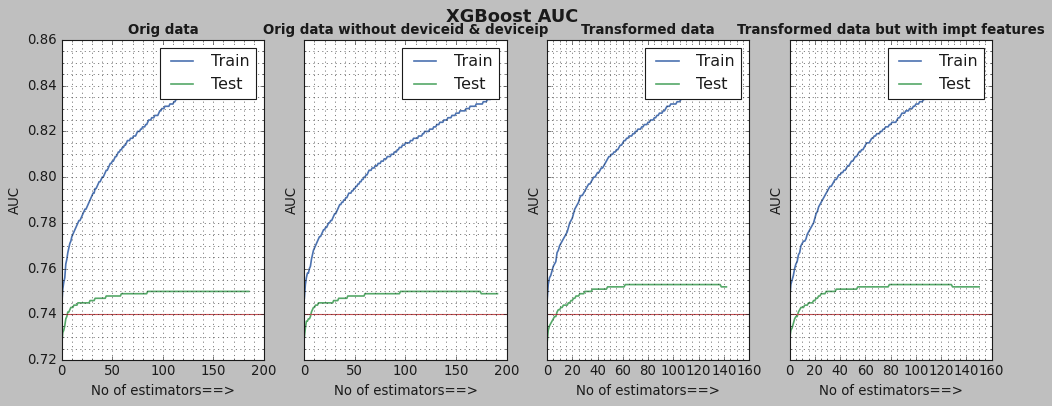

<Figure size 640x480 with 0 Axes>

In [ ]:
# 12.0 Learning curves of all the three models

plt.style.use('classic')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(), model_orig_noip.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["Orig data", 'Orig data without deviceid & deviceip', 'Transformed data', 'Transformed data but with impt features']
_=fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 16)

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    _=ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1.5, label='Train');
    _=ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1.5, label='Test');
    _=ax[i].legend();
    _=ax[i].grid(visible = True, which = 'both');
    _=ax[i].minorticks_on();
    _=ax[i].set_ylabel('AUC');
    _=ax[i].set_xlabel('No of estimators==>');
    _=ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    _=ax[i].axhline(y=0.74, color='r', linestyle='-')

_=plt.show();
_=plt.tight_layout()



## Preparing for PCA--imputing data
PCAs of transformed data

In [ ]:
# 13.0 Check if any nulls in data
#       If so, we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()  # 0
X_test_trans.isnull().sum().sum()   # 63060/65406/65932

X_train_trans.shape  # (1499627, 588)/(1499698, 750)
X_test_trans.shape   # (499876, 588)/(499900, 750)

0

65932

(1499698, 750)

(499900, 750)

In [ ]:
# 13.1 Impute as test data has null values:
#      First reduce memory requirements:
#      (We had to do it as our machine had 16gb RAM)

X_train_trans_imputed = X_train_trans.astype('float16')
X_test_trans_imputed  = X_test_trans.astype('float16')

In [ ]:
# 13.1 Impute as test data has null values:

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans_imputed[:] = si.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:] = si.transform(X_test_trans_imputed)
end = time.time()
print("Done: ", (end-start)/60)  # 2.79 min

Imputing....
Done:  2.7974180897076923


In [ ]:
# 13.1.1 Check for nulls again:

X_train_trans_imputed.isnull().sum().sum()  # 0
X_test_trans_imputed.isnull().sum().sum()   # 0

0

0

### Save imputed data

In [ ]:
# 13.2 Save imputed data for later experiments:

X_train_trans_imputed.to_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed.to_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

# 13.2.0 Datashapes:

X_train_trans_imputed.shape  # (1501119, 586)/(1499049, 582)/(1499627, 588)/(1499698, 750)
X_test_trans_imputed.shape   # (500374, 586)/(499684, 582)/(499876, 588)/(499900, 750)

(1499698, 750)

(499900, 750)

### Read imputed data

In [ ]:
# 13.2.1 Read back saved imputed data:

X_train_trans_imputed = pd.read_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

# 13.2.2 Check
X_train_trans_imputed.shape  # (1501119, 586)/(1499493, 576)/(1499627, 588)
X_test_trans_imputed.shape   # (500374, 586)/(499831, 576)/(499876, 588)

(1499698, 750)

(499900, 750)

### Perform 95% PCA

In [ ]:
# 13.2.3
ss = StandardScaler()
X_train_trans_imputed[:] = ss.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:] = ss.transform(X_test_trans_imputed)

In [ ]:
# 13.3 PCA with transformed train data.
#      Note that n_components = 0.95

gc.collect()
pca = PCA(n_components= 0.95,
          whiten= True,
          random_state = rng)

pca_train = pca.fit_transform(X_train_trans_imputed)
gc.collect()
pca_test  = pca.transform(X_test_trans_imputed)

# 13.3.1 Check data shapes:
pca_train.shape  # (1501119, 97)/(1499493, 96)/(1499627, 95)
pca_test.shape   # (500374, 97)/(499831, 96)/(499876, 95)

0

0

(1499698, 101)

(499900, 101)

In [ ]:
# 13.4 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test =  pd.DataFrame(pca_test,  columns = colnames)

# 13.4.1 Dataframe shapes:

pca_train.shape  # (1501119, 97)/(1499493, 96)/1499627, 95)/(1499698, 101)
pca_test.shape   # (500374, 97)/(499831, 96)/(499876, 95)/(499900, 101)

(1499698, 101)

(499900, 101)

### Plotting PCA

In [ ]:
# 13.5 Take a stratified sample for plotting:
#      Just 5000 samples:

_, pca_tr, _,pca_y  = train_test_split(pca_train, y_train,
                                       test_size = 5000,
                                       stratify = y_train
                                      )

# 13.5.1 Our data for plotting:
pca_tr.shape  # (5000, 97)/(5000, 95)/(5000, 101)
pca_y.shape   # (5000,)

(5000, 101)

(5000,)

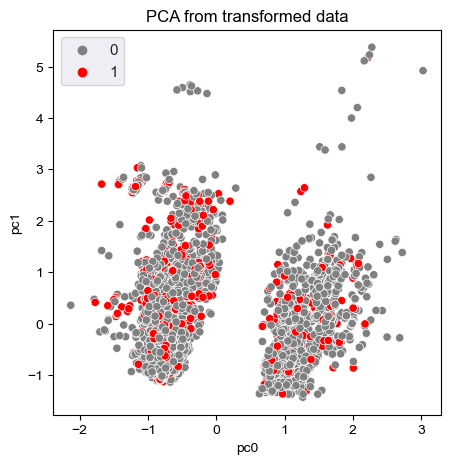

In [ ]:
# 13.6 2D PCA plot from first two principal components:
#      Two clusters are evident:

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; # Set default theme
sns.scatterplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA from transformed data') ;

### Save 95% PCA data

In [ ]:
# 14.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazudata) / "pca_train.pkl")
pca_test.to_pickle(Path(avazudata) / "pca_test.pkl")

### Read back 95% PCA data

In [ ]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazudata) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc91,pc92,pc93,pc94,pc95,pc96,pc97,pc98,pc99,pc100
0,-1.102130,2.762019,-1.932318,-1.978797,-1.226678,1.200556,-0.850126,-1.719669,0.158196,1.284829,...,0.085401,0.069769,0.412169,-0.243730,0.223895,-0.966110,0.185412,-1.574175,-0.665990,-0.181747
1,-0.747602,-0.940209,0.079358,0.137828,0.050569,0.288186,-0.198276,-0.297121,-0.295114,0.593067,...,-0.093622,0.434330,0.703078,-1.005803,0.279632,-0.065496,-0.646179,0.278885,0.461319,0.685997
2,0.801823,-0.601027,0.178976,-1.134097,-1.004995,-0.117256,0.411918,0.756779,-0.198062,-0.390146,...,-0.459665,0.249034,-0.351790,0.015610,0.339669,-0.485977,-0.447732,-0.344832,-0.184965,0.246737


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc91,pc92,pc93,pc94,pc95,pc96,pc97,pc98,pc99,pc100
0,1.416328,0.065361,-1.036184,-0.764585,0.316942,-1.238066,-1.406431,0.465184,-0.517939,0.274045,...,-0.155122,-0.080795,-0.104881,1.019546,-0.765314,1.322599,-0.589022,0.030279,0.420456,-0.298090
1,-0.822676,0.908657,-0.652014,-0.780860,-0.874015,-0.104280,0.554407,0.314008,-0.932325,0.465668,...,0.155080,0.083235,-0.570233,-0.097183,0.126548,-0.021147,-0.305196,-0.486546,-0.130737,-0.325376
2,1.213804,-1.029678,-0.201747,-0.653222,-0.776785,0.094668,-0.746524,0.277588,-0.438296,-0.248531,...,0.393232,-0.182822,-0.722722,0.546758,1.226319,-0.018726,-0.124733,-0.101862,0.383483,0.220929


### xgboost modeling with all the PCA components

In [ ]:
# 15.0 Prepare xgboost model--PCA data

# 15.0.1 We use class weights also:
#        Actually there is no benefit of class weights:

class_weights = {0: 1, 1: 10}
model_pca = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 15,
                           subsample = 0.8,
                           class_weight = class_weights,
                           random_state = rng,
                           )


tr_X =   pca_train
test_X = pca_test
ytrain = y_train
ytest = y_test


model_pca.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']
                    )

[09:22:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[09:22:57] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:23:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8380 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.73448	validation_1-auc:0.70704
[09:23:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8170 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.74561	validation_1-auc:0.71488
[09:23:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7478 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75047	validation_1-auc:0.71780
[09:23:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1

[35]	validation_0-auc:0.81197	validation_1-auc:0.73538
[09:28:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11086 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.81356	validation_1-auc:0.73558
[09:28:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10864 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.81470	validation_1-auc:0.73560
[09:28:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10256 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.81573	validation_1-auc:0.73566
[09:28:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9116 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.81660	validation_1-auc:0.73578
[09:28:52] INFO: C:\Users\dev-admin\cr

[09:33:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8578 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.84763	validation_1-auc:0.73764
[09:33:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6476 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.84837	validation_1-auc:0.73762
[09:33:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6414 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.84910	validation_1-auc:0.73765
[09:34:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8004 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.84993	validation_1-auc:0.73766
[09:34:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.87339	validation_1-auc:0.73745
[09:39:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5534 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.87405	validation_1-auc:0.73740
[09:39:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5614 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.87468	validation_1-auc:0.73738
[09:39:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5918 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.87537	validation_1-auc:0.73735
[09:39:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4908 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.87585	validation_1-auc:0.73733
[09:39:51] INFO: C:\Users\dev-admin\

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 10}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False, eta=0.06,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 15.0.2 Save model object:

utils.savePythonObject(model_pca, "model_pca.pkl", avazudata)


Object saved to: c:\avazu\allmodels\datafiles\model_pca.pkl


In [ ]:
# 15.0.3 Restore model object:

model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

In [ ]:
# 15.1 Best Scores:

model_pca.best_score     # 0.7377374624019014
model_pca.best_iteration # 80

0.7377374624019014

80

### Classification report
xgboost modeling with PCA data

In [ ]:
# 15.2 Classification report of model with PCA data:

pred = model_pca.predict(test_X)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.57      0.08      0.14     85094

    accuracy                           0.83    499900
   macro avg       0.70      0.53      0.52    499900
weighted avg       0.79      0.83      0.78    499900



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    352805
           1       0.57      0.08      0.14     72357

    accuracy                           0.83    425162
   macro avg       0.71      0.53      0.52    425162
weighted avg       0.79      0.83      0.78    425162

               precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.57      0.08      0.14     84806

    accuracy                           0.83    499684
   macro avg       0.70      0.53      0.52    499684
weighted avg       0.79      0.83      0.78    499684



"""

### Learning curve
xgboost modeling with PCA data

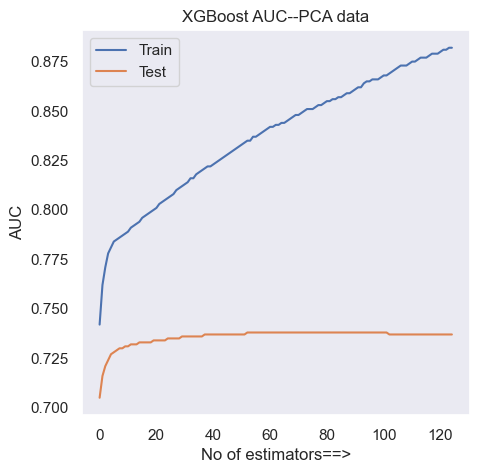

In [ ]:
# 15.3 Learning curve of xgboost based on pca data:
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,1, figsize = (5,5));

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs);
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid();
ax.set_ylabel('AUC');
ax.set_xlabel('No of estimators==>')
ax.set_title("XGBoost AUC--PCA data");

## Balanacing PCA train data with `imblearn` library
We use imblearn library
>Balance with [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)<br>
>Balance with [`SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)<br>

The former removes majority samples along the decision boundary and hence undersamples majority data. The next one not only does this but also uses SMOTE to increase minority sample.

In [ ]:
# 16.0 Call imblearn library:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

## Using `EditedNearestNeighbours`
Undersamples majority class near decision boundary

In [ ]:
# 16.1 Undersample PCA train data:

start = time.time()
undersample = EditedNearestNeighbours()
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 30min

# 16.1.1 Data shape
X_res.shape  #  (1075328, 97)/(1091067, 96)/(1089900, 95)/(1091041, 101)
y_res.shape  #  (1075328,)/(1074577, )/(1091067,)/(1089900, )/(1091041,)

30.03635104894638


(1091041, 101)

(1091041,)

### Plot of Ist two components of cleanedup data

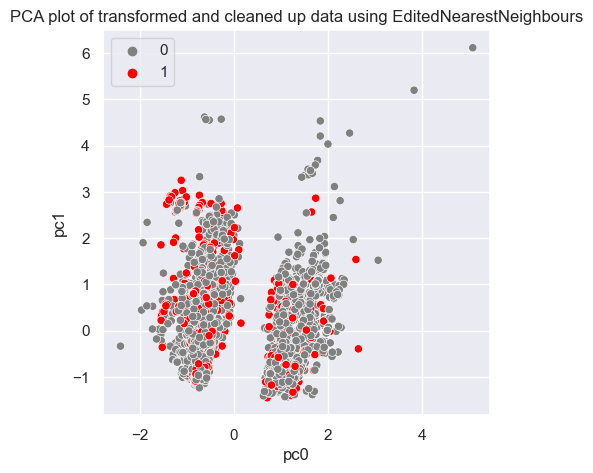

In [ ]:
# 17.0 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 5000, stratify = y_res)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ;
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

### xgboost modeling with undersampled data

In [ ]:
# 17.3 xgboost Modeling with undersampled data

model_en = xgb.XGBClassifier( n_estimators= 650 , #Needs to be reduced
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 8,
                               subsample = 0.9,
                               random_state = rng,
                           )


tr_X =   X_res
test_X = pca_test
ytrain = y_res
ytest =  y_test


model_en.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )



3964

[10:15:58] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[10:16:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.74121	validation_1-auc:0.67585
[10:16:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.74515	validation_1-auc:0.67906
[10:16:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.76224	validation_1-auc:0.69197
[10:16:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.76595	validation_1

[36]	validation_0-auc:0.79724	validation_1-auc:0.71594
[10:17:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=8
[37]	validation_0-auc:0.79774	validation_1-auc:0.71623
[10:17:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=8
[38]	validation_0-auc:0.79818	validation_1-auc:0.71649
[10:18:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=8
[39]	validation_0-auc:0.79881	validation_1-auc:0.71690
[10:18:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=8
[40]	validation_0-auc:0.79951	validation_1-auc:0.71728
[10:18:08] INFO: C:\Users\dev-admin\croot2\xgboos

[73]	validation_0-auc:0.81471	validation_1-auc:0.72522
[10:19:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=8
[74]	validation_0-auc:0.81508	validation_1-auc:0.72535
[10:19:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=8
[75]	validation_0-auc:0.81560	validation_1-auc:0.72561
[10:20:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=8
[76]	validation_0-auc:0.81591	validation_1-auc:0.72576
[10:20:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=8
[77]	validation_0-auc:0.81648	validation_1-auc:0.72604
[10:20:06] INFO: C:\Users\dev-admin\croot2\xgboos

[110]	validation_0-auc:0.82872	validation_1-auc:0.73111
[10:21:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 502 extra nodes, 0 pruned nodes, max_depth=8
[111]	validation_0-auc:0.82901	validation_1-auc:0.73120
[10:21:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=8
[112]	validation_0-auc:0.82934	validation_1-auc:0.73131
[10:22:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=8
[113]	validation_0-auc:0.82964	validation_1-auc:0.73142
[10:22:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=8
[114]	validation_0-auc:0.82999	validation_1-auc:0.73157
[10:22:09] INFO: C:\Users\dev-admin\croot2\x

[147]	validation_0-auc:0.83824	validation_1-auc:0.73416
[10:23:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=8
[148]	validation_0-auc:0.83850	validation_1-auc:0.73425
[10:24:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[149]	validation_0-auc:0.83872	validation_1-auc:0.73431
[10:24:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=8
[150]	validation_0-auc:0.83890	validation_1-auc:0.73434
[10:24:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=8
[151]	validation_0-auc:0.83916	validation_1-auc:0.73443
[10:24:11] INFO: C:\Users\dev-admin\croot2\x

[184]	validation_0-auc:0.84491	validation_1-auc:0.73571
[10:25:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=8
[185]	validation_0-auc:0.84517	validation_1-auc:0.73578
[10:26:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[186]	validation_0-auc:0.84524	validation_1-auc:0.73580
[10:26:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=8
[187]	validation_0-auc:0.84542	validation_1-auc:0.73585
[10:26:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=8
[188]	validation_0-auc:0.84554	validation_1-auc:0.73586
[10:26:12] INFO: C:\Users\dev-admin\croot2\x

[221]	validation_0-auc:0.85022	validation_1-auc:0.73671
[10:27:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[222]	validation_0-auc:0.85036	validation_1-auc:0.73673
[10:28:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[223]	validation_0-auc:0.85048	validation_1-auc:0.73676
[10:28:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=8
[224]	validation_0-auc:0.85054	validation_1-auc:0.73676
[10:28:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=8
[225]	validation_0-auc:0.85076	validation_1-auc:0.73682
[10:28:12] INFO: C:\Users\dev-admin\croot2\x

[258]	validation_0-auc:0.85485	validation_1-auc:0.73734
[10:30:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=8
[259]	validation_0-auc:0.85500	validation_1-auc:0.73735
[10:30:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[260]	validation_0-auc:0.85507	validation_1-auc:0.73736
[10:30:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=8
[261]	validation_0-auc:0.85518	validation_1-auc:0.73739
[10:30:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[262]	validation_0-auc:0.85525	validation_1-auc:0.73739
[10:30:12] INFO: C:\Users\dev-admin\croot2\x

[295]	validation_0-auc:0.85869	validation_1-auc:0.73768
[10:31:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=8
[296]	validation_0-auc:0.85885	validation_1-auc:0.73771
[10:32:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=8
[297]	validation_0-auc:0.85903	validation_1-auc:0.73775
[10:32:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=8
[298]	validation_0-auc:0.85907	validation_1-auc:0.73775
[10:32:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[299]	validation_0-auc:0.85916	validation_1-auc:0.73776
[10:32:11] INFO: C:\Users\dev-admin\croot2\x

[332]	validation_0-auc:0.86267	validation_1-auc:0.73810
[10:33:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=8
[333]	validation_0-auc:0.86271	validation_1-auc:0.73811
[10:34:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=8
[334]	validation_0-auc:0.86281	validation_1-auc:0.73811
[10:34:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=8
[335]	validation_0-auc:0.86292	validation_1-auc:0.73811
[10:34:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=8
[336]	validation_0-auc:0.86295	validation_1-auc:0.73811
[10:34:11] INFO: C:\Users\dev-admin\croot2\x

[369]	validation_0-auc:0.86601	validation_1-auc:0.73827
[10:35:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[370]	validation_0-auc:0.86606	validation_1-auc:0.73827
[10:36:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=8
[371]	validation_0-auc:0.86617	validation_1-auc:0.73828
[10:36:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[372]	validation_0-auc:0.86626	validation_1-auc:0.73828
[10:36:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=8
[373]	validation_0-auc:0.86633	validation_1-auc:0.73829
[10:36:09] INFO: C:\Users\dev-admin\croot2\x

[406]	validation_0-auc:0.86911	validation_1-auc:0.73843
[10:37:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=8
[407]	validation_0-auc:0.86915	validation_1-auc:0.73842
[10:37:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[408]	validation_0-auc:0.86927	validation_1-auc:0.73842
[10:38:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[409]	validation_0-auc:0.86934	validation_1-auc:0.73842
[10:38:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[410]	validation_0-auc:0.86941	validation_1-auc:0.73841
[10:38:08] INFO: C:\Users\dev-admin\croot2\x

[443]	validation_0-auc:0.87223	validation_1-auc:0.73855
[10:39:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[444]	validation_0-auc:0.87230	validation_1-auc:0.73855
[10:39:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=8
[445]	validation_0-auc:0.87242	validation_1-auc:0.73854
[10:40:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=8
[446]	validation_0-auc:0.87244	validation_1-auc:0.73854
[10:40:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[447]	validation_0-auc:0.87252	validation_1-auc:0.73854
[10:40:06] INFO: C:\Users\dev-admin\croot2\x

[480]	validation_0-auc:0.87518	validation_1-auc:0.73862
[10:41:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[481]	validation_0-auc:0.87525	validation_1-auc:0.73862
[10:41:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=8
[482]	validation_0-auc:0.87533	validation_1-auc:0.73862
[10:41:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=8
[483]	validation_0-auc:0.87544	validation_1-auc:0.73861
[10:42:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=8
[484]	validation_0-auc:0.87548	validation_1-auc:0.73861
[10:42:06] INFO: C:\Users\dev-admin\croot2\x

[517]	validation_0-auc:0.87790	validation_1-auc:0.73870
[10:43:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[518]	validation_0-auc:0.87797	validation_1-auc:0.73870
[10:43:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[519]	validation_0-auc:0.87804	validation_1-auc:0.73870
[10:43:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=8
[520]	validation_0-auc:0.87812	validation_1-auc:0.73870
[10:44:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[521]	validation_0-auc:0.87820	validation_1-auc:0.73871
[10:44:04] INFO: C:\Users\dev-admin\croot2\x

[554]	validation_0-auc:0.88025	validation_1-auc:0.73875
[10:45:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[555]	validation_0-auc:0.88032	validation_1-auc:0.73875
[10:45:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=8
[556]	validation_0-auc:0.88039	validation_1-auc:0.73874
[10:45:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=8
[557]	validation_0-auc:0.88046	validation_1-auc:0.73874
[10:45:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[558]	validation_0-auc:0.88053	validation_1-auc:0.73874
[10:46:02] INFO: C:\Users\dev-admin\croot2\x

[591]	validation_0-auc:0.88262	validation_1-auc:0.73872
[10:47:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[592]	validation_0-auc:0.88270	validation_1-auc:0.73873
[10:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=8
[593]	validation_0-auc:0.88272	validation_1-auc:0.73873
[10:47:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[594]	validation_0-auc:0.88277	validation_1-auc:0.73873
[10:47:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[595]	validation_0-auc:0.88285	validation_1-auc:0.73872
[10:48:00] INFO: C:\Users\dev-admin\croot2\x

[628]	validation_0-auc:0.88487	validation_1-auc:0.73867
[10:49:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=8
[629]	validation_0-auc:0.88496	validation_1-auc:0.73867
[10:49:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=8
[630]	validation_0-auc:0.88505	validation_1-auc:0.73867
[10:49:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=8
[631]	validation_0-auc:0.88511	validation_1-auc:0.73866
[10:49:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=8
[632]	validation_0-auc:0.88518	validation_1-auc:0.73865
[10:49:57] INFO: C:\Users\dev-admin\croot2\x

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=650, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 17.3.1:

utils.savePythonObject(model_en, "model_en.pkl", avazudata)

44

Object saved to: c:\avazu\allmodels\datafiles\model_en.pkl


In [ ]:
# 17.3.2

model_en = utils.restorePythonObject("model_en.pkl", avazudata)

In [ ]:
# 17.4 Scores:

model_en.best_score     # 0.7387503785918077
model_en.best_iteration # 579

0.7387503785918077

579

### Classification report
After balancing data with `EditedNearestNeighbours` class

In [ ]:
# 17.5 Classification report xgboost model with undersampled PCA data:

pred = model_en.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87    414806
           1       0.37      0.37      0.37     85094

    accuracy                           0.78    499900
   macro avg       0.62      0.62      0.62    499900
weighted avg       0.78      0.78      0.78    499900



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.87      0.86      0.87    415242
           1       0.36      0.39      0.38     85132

    accuracy                           0.78    500374
   macro avg       0.62      0.62      0.62    500374
weighted avg       0.79      0.78      0.78    500374

iter2
=====
               precision    recall  f1-score   support

           0       0.87      0.86      0.87    414878
           1       0.36      0.38      0.37     84806

    accuracy                           0.78    499684
   macro avg       0.62      0.62      0.62    499684
weighted avg       0.79      0.78      0.78    499684

"""

## Using `SMOTEENN`
For balancing PCA data

In [ ]:
# 18.0 Instantiate SMOTEEN and use it on pca_train:

start= time.time()
sm = SMOTEENN(random_state=rng, n_jobs = -1)
X_res_sm, y_res_sm = sm.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 100m (20L)

16

0

100.80298850933711


In [ ]:
# 18.0.1 Data shape after SMOTEENN

X_res_sm.shape  # (1688427, 97)/(1558844, 96)/(1557978, 95)/(1558408, 95)/(1553492, 101)
y_res_sm.shape  # (1688427,),(1558844,)/(1557978,)/(1558408,)/(1553492,)

16

(1553492, 101)

(1553492,)

In [ ]:
# 18.0.2:

y_res_sm.value_counts()
y_res_sm.value_counts(normalize = True)  # 51%:48%

1    801435
0    752057
Name: click, dtype: int64

1    0.515893
0    0.484107
Name: click, dtype: float64

### Plot of Ist two components of cleanedup data

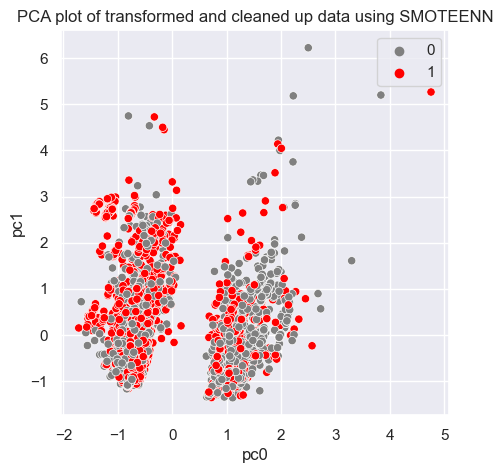

In [ ]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res_sm, y_res_sm, test_size = 5000, stratify = y_res_sm)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ;
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA plot of transformed and cleaned up data using SMOTEENN') ;

### xgboost modeling with balanced data (SMOTEENN)

In [ ]:
# 19.0 Modeling with smoteenn data

model_sm = xgb.XGBClassifier( n_estimators= 650,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_sm
test_X = pca_test
ytrain = y_res_sm
ytest =  y_test


model_sm.fit(tr_X, ytrain.values,
                early_stopping_rounds = 100,
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']
                )



[13:24:09] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:24:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1568 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.82294	validation_1-auc:0.69361
[13:24:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1584 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.83172	validation_1-auc:0.69873
[13:24:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1564 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.83864	validation_1-auc:0.70370
[13:24:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1512 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.84096	vali

[13:28:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1504 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.87137	validation_1-auc:0.72045
[13:28:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1546 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.87197	validation_1-auc:0.72067
[13:28:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1438 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.87240	validation_1-auc:0.72081
[13:28:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1432 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.87289	validation_1-auc:0.72101
[13:28:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[72]	validation_0-auc:0.89290	validation_1-auc:0.72600
[13:32:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1620 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.89362	validation_1-auc:0.72613
[13:32:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1332 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.89406	validation_1-auc:0.72620
[13:32:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1646 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.89464	validation_1-auc:0.72631
[13:32:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1680 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.89535	validation_1-auc:0.72642
[13:32:25] INFO: C:\Users\dev-admin\croot

[13:35:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1534 extra nodes, 0 pruned nodes, max_depth=10
[109]	validation_0-auc:0.91171	validation_1-auc:0.72891
[13:36:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1538 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.91213	validation_1-auc:0.72897
[13:36:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1730 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.91265	validation_1-auc:0.72903
[13:36:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1530 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.91306	validation_1-auc:0.72907
[13:36:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[145]	validation_0-auc:0.92458	validation_1-auc:0.73002
[13:39:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1462 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.92488	validation_1-auc:0.73003
[13:40:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1652 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.92527	validation_1-auc:0.73009
[13:40:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1360 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.92554	validation_1-auc:0.73013
[13:40:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1626 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.92592	validation_1-auc:0.73014
[13:40:21] INFO: C:\Users\dev-admin\

[13:43:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 876 extra nodes, 0 pruned nodes, max_depth=10
[182]	validation_0-auc:0.93422	validation_1-auc:0.73043
[13:43:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1000 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.93435	validation_1-auc:0.73044
[13:43:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1586 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.93465	validation_1-auc:0.73042
[13:44:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1442 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.93487	validation_1-auc:0.73044
[13:44:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_

[218]	validation_0-auc:0.94148	validation_1-auc:0.73053
[13:47:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 894 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.94163	validation_1-auc:0.73053
[13:47:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1582 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.94190	validation_1-auc:0.73054
[13:47:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1070 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.94204	validation_1-auc:0.73055
[13:47:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1486 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.94225	validation_1-auc:0.73054
[13:47:58] INFO: C:\Users\dev-admin\c

[13:51:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1314 extra nodes, 0 pruned nodes, max_depth=10
[255]	validation_0-auc:0.94797	validation_1-auc:0.73041
[13:51:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1180 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.94812	validation_1-auc:0.73040
[13:51:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1184 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.94825	validation_1-auc:0.73041
[13:51:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.94830	validation_1-auc:0.73042
[13:51:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_

[291]	validation_0-auc:0.95255	validation_1-auc:0.73024
[13:55:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1364 extra nodes, 0 pruned nodes, max_depth=10
[292]	validation_0-auc:0.95269	validation_1-auc:0.73023
[13:55:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1498 extra nodes, 0 pruned nodes, max_depth=10
[293]	validation_0-auc:0.95287	validation_1-auc:0.73024
[13:55:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[294]	validation_0-auc:0.95291	validation_1-auc:0.73023
[13:55:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1220 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.95303	validation_1-auc:0.73022
[13:55:33] INFO: C:\Users\dev-admin\c

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=650, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 19.0.1

utils.savePythonObject(model_sm, "model_sm.pkl", avazudata)

3763

Object saved to: c:\avazu\allmodels\datafiles\model_sm.pkl


In [ ]:
# 19.0.2
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

In [ ]:
# 19.1 score
model_sm.best_score   # 0.7320805711/0.73260329129(20L)/0.7305378582/0.730988385236/0.7305738525325511
model_sm.best_iteration  # 230/222/308/213

0.7305738525325511

213

### Classification report
After balancing with `SMOTEENN` class

In [ ]:
# 19.2
pred = model_sm.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74    414806
           1       0.28      0.72      0.40     85094

    accuracy                           0.64    499900
   macro avg       0.60      0.67      0.57    499900
weighted avg       0.81      0.64      0.68    499900



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.93      0.54      0.69    415242
           1       0.26      0.79      0.40     85132

    accuracy                           0.59    500374
   macro avg       0.60      0.67      0.54    500374
weighted avg       0.82      0.59      0.64    500374


               precision    recall  f1-score   support

           0       0.93      0.55      0.69    414878
           1       0.26      0.79      0.40     84806

    accuracy                           0.59    499684
   macro avg       0.60      0.67      0.54    499684
weighted avg       0.81      0.59      0.64    499684

"""

### Learning plots
xgboost modeling with the two class balancing techniques

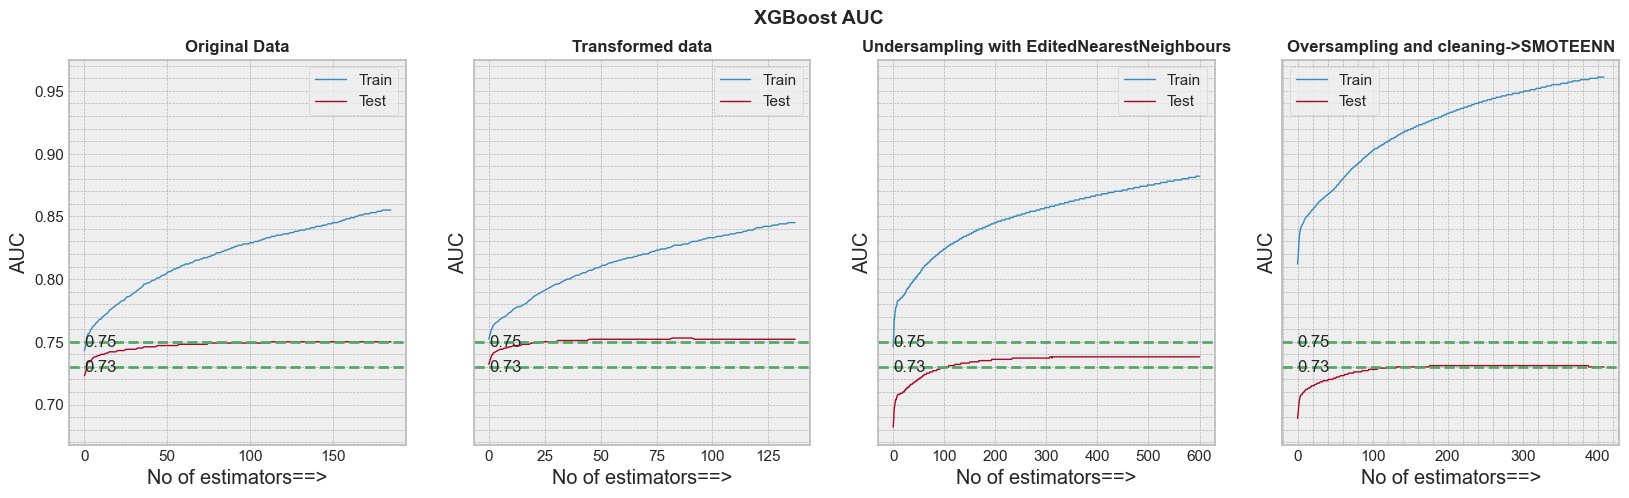

In [ ]:
# 19.3 Learning curves: xgboost modeling

plt.style.use('bmh')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result()]
title = ["Original Data", "Transformed data", "Undersampling with EditedNearestNeighbours", 'Oversampling and cleaning->SMOTEENN']
fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 14)
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y=0.75, color='g', linestyle='--', label='p=0.05')
    ax[i].axhline(y=0.73, color='g', linestyle='--')
    ax[i].text(0, 0.75, '0.75', ha='left', va='center')
    ax[i].text(0, 0.73, '0.73', ha='left', va='center')

plt.show();

## Distribution of transformed features:
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

eigenvector          0.369863
degree               0.315068
pagerank             0.315068
clusteringcoeff      0.000000
betweenness          0.000000
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

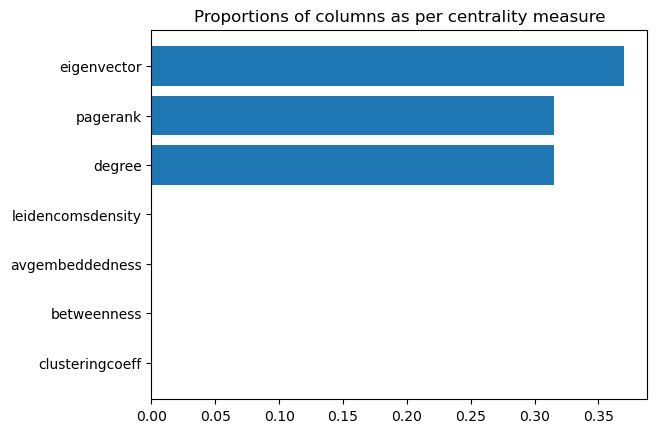

In [ ]:
# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")


### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 411'

'Columns whose impt is 0: 177'

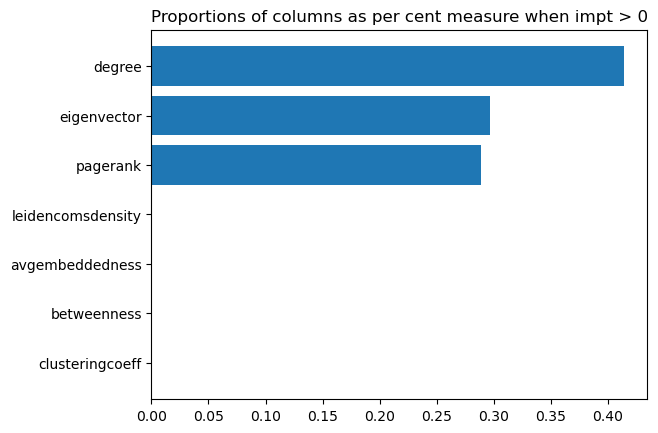

In [ ]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


deg_Ctwentyone_ck_devicemodel    0.228290
pr_Ctwentyone_ck_devicemodel     0.090174
deg_Cseventeen_ck_Csixteen       0.076567
deg_Cseventeen_ck_Ceighteen      0.058265
eig_appdomain_ck_Ctwentyone      0.029723
Name: imp, dtype: float32

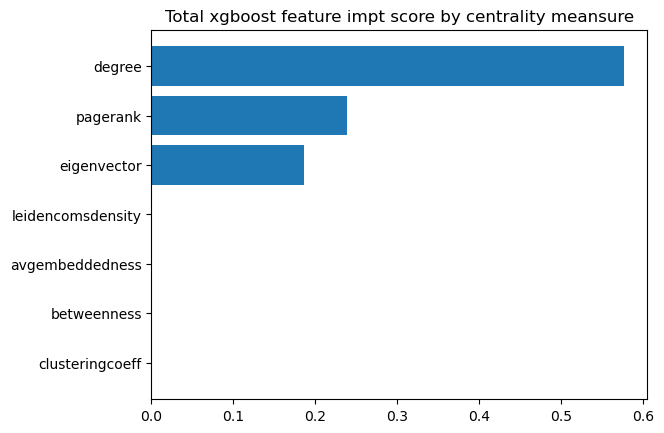

In [ ]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Derive unitvectors
tsv files and meta files created in unitvectors folder can be fed into embedding projector (unfortunately files have large size and there is problem loading into Embedding Projector)

### Readback saved data

In [ ]:
# 21.2 Readback all saved files:

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test for concatenation
#        of cat cols to be possible with transformed data:

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Recheck indexing:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)/(1499627, 603)/(1499698, 765)
y_train.shape       # (1501119,)/(1499627, )
test_trans.shape    # (499831, 591)/(499876, 603)/(499900, 765)
y_test.shape        # (500374,)/(499876, )


f"Total cols in X_train: {X_train.shape[1]}"
# 21.2.4 Our list of cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

f"Length of cat cols: {len(cat_cols)}"

# 21.2.5 Remaining cols not treated as cat cols:
rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols
f"Length of remaining cols: {len(rem_cols)}"



# 21.3 Concat rem_cols with transformed data:
# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
transcols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate (exclude device_id and device):
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[transcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1499493, 576)/(1499627, 588) (603-19+4 = 588)/(1499698, 765)/(1499698, 750)
X_test_trans.shape   # (499831, 576)/(499876, 588)/(499900, 750)/(1499698, 750)

# 21.7 Read back saved imputed data:

X_train_trans_imputed = pd.read_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

#  21.7.1 Check
X_train_trans_imputed.shape  # (1501119, 586)/(1499493, 576)/(1499627, 588)/(1499698, 750)
X_test_trans_imputed.shape   # (500374, 586)/(499831, 576)/(499876, 588)/(499900, 750)

# 21.8 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

771

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1102,1665,3,3667,107,0,1203,1,...,0.151011,0.271186,0.032768,0.009207,0.203390,0.068588,0.010675,0.915254,0.142844,0.019491
1,1005,0,359,3339,1,3667,107,0,563,1,...,-0.034182,0.694915,0.141788,0.016860,0.457627,0.170485,0.020274,0.915254,0.143742,0.019360


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1575,2720,5,3277,6,4,4606,1,...,0.118601,0.559322,0.081644,0.015594,0.186441,0.057565,0.011602,0.915254,0.142844,0.019491
1,1005,0,359,3339,1,3667,107,0,847,1,...,0.113822,0.711864,0.142679,0.017328,0.491525,0.173426,0.022475,0.949153,0.144855,0.020258


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1102,1665,3,3667,107,0,184979,384356,...,250,2162,2,39,100101,33,10,3,30,15
1,1005,0,359,3339,1,3667,107,0,184979,51728,...,50,1722,0,35,-1,79,10,1,21,6


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1575,2720,5,3277,6,4,184979,33570,...,50,122,3,1327,-1,15,10,3,23,15
1,1005,0,359,3339,1,3667,107,0,184979,914979,...,50,2616,0,35,-1,51,10,3,30,13


(1499698, 765)

(1499698,)

(499900, 765)

(499900,)

'Total cols in X_train: 25'

'Length of cat cols: 19'

'Length of remaining cols: 6'

(1499698, 750)

(499900, 750)

(1499698, 750)

(499900, 750)

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], cutoff=4,
                  mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

In [ ]:
# 22.0 Now horizontally concatenate (exclude device_id and device):

X_train_trans_imputed = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed = pd.concat([X_test[cat_cols], X_test_trans_imputed ], axis = 1)

X_train_trans_imputed.shape # (1499627, 607) ((603-19+4) +19 = 607 )/(1499698, 769)
X_test_trans_imputed.shape # (499876, 607)   ((603-19+4) +19 = 607)/(499900, 769)

(1499698, 769)

(499900, 769)

In [ ]:
# 22.0.0.1 Columns included all cat_cols as also transformed columns+time cols:

X_train_trans_imputed.columns[:30]
X_train_trans_imputed.columns[-25:]

Index(['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
       'appdomain', 'appcategory', 'devicemodel', 'devicetype',
       'deviceconntype', 'Cfourteen', 'Cfifteen', 'Csixteen', 'Cseventeen',
       'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone', 'day', 'dayofweek',
       'hour_time', 'month', 'deg_Cone_ck_bannerpos', 'eig_Cone_ck_bannerpos',
       'pr_Cone_ck_bannerpos', 'eig_Cone_ck_siteid', 'eig_Cone_ck_sitedomain',
       'eig_Cone_ck_sitecategory', 'deg_Cone_ck_appid'],
      dtype='object')

Index(['pr_Ctwentyone_ck_appcategory', 'deg_Ctwentyone_ck_devicemodel',
       'eig_Ctwentyone_ck_devicemodel', 'pr_Ctwentyone_ck_devicemodel',
       'deg_Ctwentyone_ck_devicetype', 'eig_Ctwentyone_ck_devicetype',
       'pr_Ctwentyone_ck_devicetype', 'eig_Ctwentyone_ck_deviceconntype',
       'eig_Ctwentyone_ck_Cfourteen', 'deg_Ctwentyone_ck_Cfifteen',
       'eig_Ctwentyone_ck_Cfifteen', 'pr_Ctwentyone_ck_Cfifteen',
       'deg_Ctwentyone_ck_Csixteen', 'eig_Ctwentyone_ck_Csixteen',
       'pr_Ctwentyone_ck_Csixteen', 'eig_Ctwentyone_ck_Cseventeen',
       'deg_Ctwentyone_ck_Ceighteen', 'eig_Ctwentyone_ck_Ceighteen',
       'pr_Ctwentyone_ck_Ceighteen', 'deg_Ctwentyone_ck_Cnineteen',
       'eig_Ctwentyone_ck_Cnineteen', 'pr_Ctwentyone_ck_Cnineteen',
       'deg_Ctwentyone_ck_Ctwenty', 'eig_Ctwentyone_ck_Ctwenty',
       'pr_Ctwentyone_ck_Ctwenty'],
      dtype='object')

In [ ]:
# 22.0.0.2:
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)
X_train_trans_imputed = X_train_trans_imputed[fe_1]
X_test_trans_imputed = X_test_trans_imputed[fe_1]

In [ ]:
# 22.0.1 Now horizontally concatenate (exclude device_id and device):

X_train_trans_imputed = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed = pd.concat([X_test[cat_cols], X_test_trans_imputed ], axis = 1)

X_train_trans_imputed.shape # (1499627, 607) ((603-19+4) +19 = 607 )
X_test_trans_imputed.shape # (499876, 607)   ((603-19+4) +19 = 607)

(1499698, 438)

(499900, 438)

In [ ]:
# 22.0.2 'target' is not here

'target' in list(X_train_trans_imputed.columns)
'target' in list(X_test_trans_imputed.columns)

False

False

In [ ]:
# 22.0.3 Get target data col.
#        Needed for generation of meta-data file:

X_test_trans_imputed['target']  =  y_test
X_train_trans_imputed['target'] =  y_train

In [ ]:
# 22.0.4 Derive unit vectors:

p = Path(avazuunitvecs)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(X_train_trans_imputed,
                           take_mean = False,
                           filepath = avazuunitvecs ,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )



Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['deviceconntype', 'Ceighteen']
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'c:\avazu\allmodels\unitvectors'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [ ]:
# 22.1 Save dict:

utils.savePythonObject(vec_tr, "vec_tr.pkl", avazuunitvecs )

Object saved to: c:\avazu\allmodels\unitvectors\vec_tr.pkl


In [ ]:
# 22.2 Unit vectors from test data. But not being saved to file:

vec_te,_ = ct.vectorsToTSV(X_test_trans_imputed,
                           take_mean = False,
                           filepath = avazuunitvecs ,
                           impute = True,
                           saveVectorsToDisk = False
                           )

19

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['deviceconntype', 'Ceighteen']


### Save unitvectors files
Also save output dictionaries for later use

In [ ]:
# 22.3 Save dict:

utils.savePythonObject(vec_te, "vec_te.pkl",avazuunitvecs )

Object saved to: c:\avazu\allmodels\unitvectors\vec_te.pkl


### Restore unitvectors files

In [ ]:
# 22.4 Restore back:

vec_tr = utils.restorePythonObject( "vec_tr.pkl", avazuunitvecs )
vec_te = utils.restorePythonObject("vec_te.pkl",avazuunitvecs )

### Using unit vectors to transform train/test data

In [ ]:
# 22.4.1

vectr = vec_tr.copy()
vecte = vec_te.copy()

In [ ]:
# 22.4.2

for key,values in vectr.items():
    print(key,vectr[key].shape[1])

Cone 6
bannerpos 4
siteid 35
sitedomain 33
sitecategory 12
appid 40
appdomain 32
appcategory 17
devicemodel 52
Cfourteen 45
Cfifteen 3
Csixteen 2
Cseventeen 50
Cnineteen 27
Ctwenty 31
Ctwentyone 26


In [ ]:
# 22.4.3

del vectr['devicetype']
del vecte['devicetype']

In [ ]:
# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vectr, vecte, n_components = 2)

# 23.1

cctr.head(3)
ccte.head(3)

# 23.2

cctr.shape   #  (1499493, 48)/(1499627, 48)
ccte.shape   #  (499831, 48)/(499876, 48)

Performing PCA for Cone for train data
Performing PCA for Cone for test data
Performing PCA for bannerpos for train data
Performing PCA for bannerpos for test data
Performing PCA for siteid for train data
Performing PCA for siteid for test data
Performing PCA for sitedomain for train data
Performing PCA for sitedomain for test data
Performing PCA for sitecategory for train data
Performing PCA for sitecategory for test data
Performing PCA for appid for train data
Performing PCA for appid for test data
Performing PCA for appdomain for train data
Performing PCA for appdomain for test data
Performing PCA for appcategory for train data
Performing PCA for appcategory for test data
Performing PCA for devicemodel for train data
Performing PCA for devicemodel for test data
Performing PCA for Cfourteen for train data
Performing PCA for Cfourteen for test data
Performing PCA for Cfifteen for train data
Performing PCA for Cfifteen for test data
Performing PCA for Csixteen for train data
Performing

,pcCone0,pcCone1,pcbannerpos0,pcbannerpos1,pcsiteid0,pcsiteid1,pcsitedomain0,pcsitedomain1,pcsitecategory0,pcsitecategory1,...,pcCsixteen0,pcCsixteen1,pcCseventeen0,pcCseventeen1,pcCnineteen0,pcCnineteen1,pcCtwenty0,pcCtwenty1,pcCtwentyone0,pcCtwentyone1
0,0.581001,0.05918,0.605965,-0.603488,-4.609655,3.786494,-6.752192,4.012943,-0.465173,4.405540,...,1.101649,2.011192,14.887827,-4.186817,0.143371,-2.198293,1.514483,-3.040481,-13.593432,-4.702157
1,0.581001,0.05918,0.605965,-0.603488,-4.156096,-1.396915,-5.641333,-1.220889,-1.323852,0.292909,...,-0.189521,-0.085208,-0.834507,-0.856240,-4.536388,1.349947,-3.983723,0.721994,0.246743,1.409277
2,0.581001,0.05918,0.605965,-0.603488,5.657921,0.091492,5.471102,-0.195994,-1.722176,-1.167692,...,-0.189521,-0.085208,-1.142674,-0.039829,-4.536388,1.349947,-3.983723,0.721994,3.188552,-1.876509


,pcCone0,pcCone1,pcbannerpos0,pcbannerpos1,pcsiteid0,pcsiteid1,pcsitedomain0,pcsitedomain1,pcsitecategory0,pcsitecategory1,...,pcCsixteen0,pcCsixteen1,pcCseventeen0,pcCseventeen1,pcCnineteen0,pcCnineteen1,pcCtwenty0,pcCtwenty1,pcCtwentyone0,pcCtwentyone1
0,0.580452,0.051902,0.624267,-0.583277,5.659823,0.089795,5.474217,-0.191181,-1.704516,-1.181824,...,-0.187025,-0.082874,0.601900,2.110449,4.253309,0.136561,-3.574029,0.680895,-3.120828,1.008538
1,0.580452,0.051902,0.624267,-0.583277,-4.159004,-1.396196,-5.637734,-1.216660,-1.315245,0.292787,...,-0.187025,-0.082874,11.068941,3.886238,-4.532751,1.353721,-3.574029,0.680895,0.510179,-0.201777
2,0.580452,0.051902,0.624267,-0.583277,5.659823,0.089795,5.474217,-0.191181,-1.704516,-1.181824,...,-0.187025,-0.082874,-1.544234,-1.881316,-4.532751,1.353721,3.709878,-0.156455,3.213846,-1.887132


(1499698, 32)

(499900, 32)

### Save unitvectors transformed train/test

In [ ]:
# 23.3 Save cctr/ccte

cctr.to_pickle(avazuunitvecs  / "cctr.pkl")
ccte.to_pickle(avazuunitvecs  / "ccte.pkl")


### Readback unitvectors transformed train/test

In [ ]:
# 24.0 Read back cctr/ccte

cctr = pd.read_pickle(avazuunitvecs  / "cctr.pkl")
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (1499049, 48)/(1499627, 48)/(1499698, 32)
ccte.shape # (499684, 48)/(499876, 48)/(499900, 32)

,pcCone0,pcCone1,pcbannerpos0,pcbannerpos1,pcsiteid0,pcsiteid1,pcsitedomain0,pcsitedomain1,pcsitecategory0,pcsitecategory1,...,pcCsixteen0,pcCsixteen1,pcCseventeen0,pcCseventeen1,pcCnineteen0,pcCnineteen1,pcCtwenty0,pcCtwenty1,pcCtwentyone0,pcCtwentyone1
0,0.581001,0.05918,0.605965,-0.603488,-4.609655,3.786494,-6.752192,4.012943,-0.465173,4.405540,...,1.101649,2.011192,14.887827,-4.186817,0.143371,-2.198293,1.514483,-3.040481,-13.593432,-4.702157
1,0.581001,0.05918,0.605965,-0.603488,-4.156096,-1.396915,-5.641333,-1.220889,-1.323852,0.292909,...,-0.189521,-0.085208,-0.834507,-0.856240,-4.536388,1.349947,-3.983723,0.721994,0.246743,1.409277


,pcCone0,pcCone1,pcbannerpos0,pcbannerpos1,pcsiteid0,pcsiteid1,pcsitedomain0,pcsitedomain1,pcsitecategory0,pcsitecategory1,...,pcCsixteen0,pcCsixteen1,pcCseventeen0,pcCseventeen1,pcCnineteen0,pcCnineteen1,pcCtwenty0,pcCtwenty1,pcCtwentyone0,pcCtwentyone1
0,0.580452,0.051902,0.624267,-0.583277,5.659823,0.089795,5.474217,-0.191181,-1.704516,-1.181824,...,-0.187025,-0.082874,0.601900,2.110449,4.253309,0.136561,-3.574029,0.680895,-3.120828,1.008538
1,0.580452,0.051902,0.624267,-0.583277,-4.159004,-1.396196,-5.637734,-1.216660,-1.315245,0.292787,...,-0.187025,-0.082874,11.068941,3.886238,-4.532751,1.353721,-3.574029,0.680895,0.510179,-0.201777


(1499698, 32)

(499900, 32)

### xgboost modeling with unitvectors

In [ ]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )


tr_X   =  cctr
test_X =  ccte
ytrain =  y_train
ytest  =  y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[17:12:32] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:12:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4150 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73338	validation_1-auc:0.72020
[17:12:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3988 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73727	validation_1-auc:0.72312
[17:12:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3948 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.73955	validation_1-auc:0.72543
[17:12:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4082 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.74080	vali

[17:13:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4668 extra nodes, 0 pruned nodes, max_depth=13
[36]	validation_0-auc:0.76178	validation_1-auc:0.74030
[17:13:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4030 extra nodes, 0 pruned nodes, max_depth=13
[37]	validation_0-auc:0.76219	validation_1-auc:0.74038
[17:13:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3840 extra nodes, 0 pruned nodes, max_depth=13
[38]	validation_0-auc:0.76254	validation_1-auc:0.74048
[17:13:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3612 extra nodes, 0 pruned nodes, max_depth=13
[39]	validation_0-auc:0.76282	validation_1-auc:0.74048
[17:13:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[72]	validation_0-auc:0.77230	validation_1-auc:0.74266
[17:14:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2456 extra nodes, 0 pruned nodes, max_depth=13
[73]	validation_0-auc:0.77253	validation_1-auc:0.74271
[17:14:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2132 extra nodes, 0 pruned nodes, max_depth=13
[74]	validation_0-auc:0.77269	validation_1-auc:0.74272
[17:14:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2466 extra nodes, 0 pruned nodes, max_depth=13
[75]	validation_0-auc:0.77296	validation_1-auc:0.74282
[17:14:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2378 extra nodes, 0 pruned nodes, max_depth=13
[76]	validation_0-auc:0.77324	validation_1-auc:0.74286
[17:14:06] INFO: C:\Users\dev-admin\croot

[17:14:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3196 extra nodes, 0 pruned nodes, max_depth=13
[109]	validation_0-auc:0.78009	validation_1-auc:0.74363
[17:14:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1764 extra nodes, 0 pruned nodes, max_depth=13
[110]	validation_0-auc:0.78027	validation_1-auc:0.74365
[17:14:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5406 extra nodes, 0 pruned nodes, max_depth=13
[111]	validation_0-auc:0.78087	validation_1-auc:0.74369
[17:14:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1384 extra nodes, 0 pruned nodes, max_depth=13
[112]	validation_0-auc:0.78101	validation_1-auc:0.74373
[17:14:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[145]	validation_0-auc:0.78703	validation_1-auc:0.74442
[17:15:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1950 extra nodes, 0 pruned nodes, max_depth=13
[146]	validation_0-auc:0.78721	validation_1-auc:0.74438
[17:15:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2660 extra nodes, 0 pruned nodes, max_depth=13
[147]	validation_0-auc:0.78749	validation_1-auc:0.74440
[17:15:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1116 extra nodes, 0 pruned nodes, max_depth=13
[148]	validation_0-auc:0.78762	validation_1-auc:0.74441
[17:15:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1870 extra nodes, 0 pruned nodes, max_depth=13
[149]	validation_0-auc:0.78778	validation_1-auc:0.74444
[17:15:35] INFO: C:\Users\dev-admin\

[17:16:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1356 extra nodes, 0 pruned nodes, max_depth=13
[182]	validation_0-auc:0.79264	validation_1-auc:0.74393
[17:16:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1226 extra nodes, 0 pruned nodes, max_depth=13
[183]	validation_0-auc:0.79272	validation_1-auc:0.74394
[17:16:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1180 extra nodes, 0 pruned nodes, max_depth=13
[184]	validation_0-auc:0.79279	validation_1-auc:0.74394
[17:16:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1586 extra nodes, 0 pruned nodes, max_depth=13
[185]	validation_0-auc:0.79290	validation_1-auc:0.74393
[17:16:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 24.1.1 Save and restore estimators:

utils.savePythonObject(model_vec, "model_vec.pkl", avazudata)



Object saved to: c:\avazu\allmodels\datafiles\model_vec.pkl


In [ ]:
# 24.1.2 Restore

model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

In [ ]:
# 24.2 Best scores:

model_vec.best_score   # 0.7461641340935019
print("\n")
model_vec.best_iteration  # 59

0.744472437885137

157

#### Classification report


In [ ]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.62      0.07      0.12     85094

    accuracy                           0.83    499900
   macro avg       0.73      0.53      0.51    499900
weighted avg       0.80      0.83      0.77    499900



### xgboost modeling with only pc0s of unitvectors

In [ ]:
# 25.0 Columns containing only Ist PCs:

pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)
len(pc0cols)  # 16

['pcCone0', 'pcbannerpos0', 'pcsiteid0', 'pcsitedomain0', 'pcsitecategory0', 'pcappid0', 'pcappdomain0', 'pcappcategory0', 'pcdevicemodel0', 'pcCfourteen0', 'pcCfifteen0', 'pcCsixteen0', 'pcCseventeen0', 'pcCnineteen0', 'pcCtwenty0', 'pcCtwentyone0']


16

In [ ]:
# 25.1 How good are pc0's of respective unit vectors and which one is most important?
#      Time features are not included.

model_vec_pc0 = xgb.XGBClassifier( n_estimators= 500,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.8,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )


tr_X =    cctr[pc0cols]
test_X =  ccte[pc0cols]
ytrain =  y_train
ytest = y_test
r

model_vec_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

44

[17:52:50] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:52:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1144 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.72050	validation_1-auc:0.70301
[17:52:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1188 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.72339	validation_1-auc:0.70590
[17:52:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1234 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.72570	validation_1-auc:0.71055
[17:52:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1192 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.72649	vali

[17:53:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 924 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.73642	validation_1-auc:0.72499
[17:53:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 984 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.73669	validation_1-auc:0.72517
[17:53:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 962 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.73693	validation_1-auc:0.72511
[17:53:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 978 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.73727	validation_1-auc:0.72525
[17:53:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.74584	validation_1-auc:0.72969
[17:53:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.74602	validation_1-auc:0.72980
[17:53:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 778 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.74614	validation_1-auc:0.72985
[17:53:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1002 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.74643	validation_1-auc:0.73002
[17:53:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 844 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.74663	validation_1-auc:0.73022
[17:53:45] INFO: C:\Users\dev-admin\croot2\x

[109]	validation_0-auc:0.75343	validation_1-auc:0.73338
[17:54:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.75351	validation_1-auc:0.73340
[17:54:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.75358	validation_1-auc:0.73343
[17:54:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 776 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.75373	validation_1-auc:0.73350
[17:54:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1318 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.75398	validation_1-auc:0.73359
[17:54:15] INFO: C:\Users\dev-admin\cro

[17:54:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 852 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.75785	validation_1-auc:0.73449
[17:54:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1252 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.75804	validation_1-auc:0.73452
[17:54:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.75812	validation_1-auc:0.73458
[17:54:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.75819	validation_1-auc:0.73461
[17:54:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[182]	validation_0-auc:0.76112	validation_1-auc:0.73559
[17:55:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1138 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.76131	validation_1-auc:0.73558
[17:55:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 790 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.76141	validation_1-auc:0.73560
[17:55:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.76147	validation_1-auc:0.73562
[17:55:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 866 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.76161	validation_1-auc:0.73565
[17:55:10] INFO: C:\Users\dev-admin\cro

[17:55:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1112 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.76463	validation_1-auc:0.73607
[17:55:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.76464	validation_1-auc:0.73606
[17:55:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.76466	validation_1-auc:0.73601
[17:55:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.76474	validation_1-auc:0.73601
[17:55:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[255]	validation_0-auc:0.76751	validation_1-auc:0.73603
[17:56:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 882 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.76761	validation_1-auc:0.73604
[17:56:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 888 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.76772	validation_1-auc:0.73592
[17:56:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 562 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.76778	validation_1-auc:0.73592
[17:56:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.76781	validation_1-auc:0.73592
[17:56:06] INFO: C:\Users\dev-admin\croo

[17:56:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[17:56:31] ======== Monitor (0): Learner ========
[17:56:31] Configure: 0.000322s, 1 calls @ 322us

[17:56:31] EvalOneIter: 77.1752s, 293 calls @ 77175232us

[17:56:31] GetGradient: 1.02834s, 293 calls @ 1028341us

[17:56:31] PredictRaw: 0.002283s, 293 calls @ 2283us

[17:56:31] UpdateOneIter: 142.979s, 293 calls @ 142978599us

[17:56:31] ======== Monitor (0): GBTree ========
[17:56:31] BoostNewTrees: 141.944s, 293 calls @ 141943822us

[17:56:31] CommitModel: 0.000131s, 293 calls @ 131us

[17:56:31] ======== Monitor (0): TreePruner ========
[17:56:31] PrunerUpdate: 0.045537s, 293 calls @ 45537us



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 25.2 Save model:

utils.savePythonObject(model_vec_pc0, "model_vec_pc0.pkl", avazuestimators  )

Object saved to: c:\avazu\allmodels\estimators\model_vec_pc0.pkl


In [ ]:
# 25.3 Restore model:

model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", avazuestimators  )

In [ ]:
# 25.4 Best scores:

model_vec_pc0.best_score   # 0.7436607269651191/0.7348892041123435/0.7362513524258832
print("\n")
model_vec_pc0.best_iteration  # 247/242

0.7362513524258832

242

In [ ]:
# 24.5 Classification report:

pred_vec = model_vec_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.58      0.08      0.15     85094

    accuracy                           0.83    499900
   macro avg       0.71      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



### xgboost modeling original data but with those cols that exist in pc0s

In [ ]:
# 26.0 List of cat-cols in X_train excluding deviceid and deviceip:

len(pc0cols)

pccols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
          'appdomain', 'appcategory', 'devicemodel', 'Cfourteen', 'Cfifteen',
          'Csixteen', 'Cseventeen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']

len(pccols) # 16

16

16

In [ ]:
# 26.1  Determine feature importance in actual data:
#       Use the same 16 features as exist in pc0s
#      (Time features, therefore, are not included.)

model_orig_few = xgb.XGBClassifier( n_estimators= 500,
                                    verbosity = 3,
                                    eta = 0.06,
                                    max_depth = 10,
                                   subsample = 0.8,
                                   random_state = rng,
                                   #reg_lambda = 1.5,
                                 )


tr_X =    X_train[pccols]
test_X =  X_test[pccols]
ytrain =  y_train
ytest = y_test


model_orig_few.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[17:59:37] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:59:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1200 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.71787	validation_1-auc:0.71495
[17:59:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1158 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.72017	validation_1-auc:0.71679
[17:59:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1230 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.72173	validation_1-auc:0.71832
[17:59:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1226 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.72228	vali

[18:00:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1388 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.74092	validation_1-auc:0.73448
[18:00:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1282 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.74131	validation_1-auc:0.73475
[18:00:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1190 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.74154	validation_1-auc:0.73487
[18:00:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1020 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.74192	validation_1-auc:0.73511
[18:00:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[72]	validation_0-auc:0.75024	validation_1-auc:0.74057
[18:00:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1160 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.75061	validation_1-auc:0.74082
[18:00:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 814 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.75073	validation_1-auc:0.74089
[18:00:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 790 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.75088	validation_1-auc:0.74096
[18:00:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1358 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.75122	validation_1-auc:0.74114
[18:00:36] INFO: C:\Users\dev-admin\croot2\

[109]	validation_0-auc:0.75674	validation_1-auc:0.74387
[18:01:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.75680	validation_1-auc:0.74389
[18:01:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1188 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.75703	validation_1-auc:0.74402
[18:01:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.75708	validation_1-auc:0.74403
[18:01:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1072 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.75728	validation_1-auc:0.74410
[18:01:05] INFO: C:\Users\dev-admin\cr

[18:01:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1104 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.76091	validation_1-auc:0.74547
[18:01:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.76094	validation_1-auc:0.74548
[18:01:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.76100	validation_1-auc:0.74549
[18:01:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 838 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.76115	validation_1-auc:0.74558
[18:01:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[182]	validation_0-auc:0.76423	validation_1-auc:0.74661
[18:01:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 806 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.76432	validation_1-auc:0.74663
[18:01:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.76437	validation_1-auc:0.74664
[18:01:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 682 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.76444	validation_1-auc:0.74666
[18:01:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 622 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.76452	validation_1-auc:0.74668
[18:02:00] INFO: C:\Users\dev-admin\croo

[18:02:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 756 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.76708	validation_1-auc:0.74733
[18:02:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 856 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.76720	validation_1-auc:0.74736
[18:02:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 774 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.76728	validation_1-auc:0.74738
[18:02:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.76733	validation_1-auc:0.74739
[18:02:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[255]	validation_0-auc:0.76966	validation_1-auc:0.74790
[18:02:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.76972	validation_1-auc:0.74792
[18:02:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 864 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.76982	validation_1-auc:0.74795
[18:02:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.76984	validation_1-auc:0.74795
[18:02:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.76989	validation_1-auc:0.74797
[18:02:54] INFO: C:\Users\dev-admin\croo

[292]	validation_0-auc:0.77150	validation_1-auc:0.74823
[18:03:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 978 extra nodes, 0 pruned nodes, max_depth=10
[293]	validation_0-auc:0.77162	validation_1-auc:0.74825
[18:03:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[294]	validation_0-auc:0.77168	validation_1-auc:0.74826
[18:03:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.77174	validation_1-auc:0.74828
[18:03:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 822 extra nodes, 0 pruned nodes, max_depth=10
[296]	validation_0-auc:0.77183	validation_1-auc:0.74829
[18:03:21] INFO: C:\Users\dev-admin\croo

[329]	validation_0-auc:0.77373	validation_1-auc:0.74852
[18:03:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 600 extra nodes, 0 pruned nodes, max_depth=10
[330]	validation_0-auc:0.77379	validation_1-auc:0.74854
[18:03:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 894 extra nodes, 0 pruned nodes, max_depth=10
[331]	validation_0-auc:0.77389	validation_1-auc:0.74856
[18:03:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=10
[332]	validation_0-auc:0.77389	validation_1-auc:0.74856
[18:03:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[333]	validation_0-auc:0.77396	validation_1-auc:0.74856
[18:03:48] INFO: C:\Users\dev-admin\croo

[366]	validation_0-auc:0.77578	validation_1-auc:0.74878
[18:04:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 840 extra nodes, 0 pruned nodes, max_depth=10
[367]	validation_0-auc:0.77586	validation_1-auc:0.74879
[18:04:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 734 extra nodes, 0 pruned nodes, max_depth=10
[368]	validation_0-auc:0.77591	validation_1-auc:0.74880
[18:04:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 772 extra nodes, 0 pruned nodes, max_depth=10
[369]	validation_0-auc:0.77598	validation_1-auc:0.74880
[18:04:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[370]	validation_0-auc:0.77601	validation_1-auc:0.74881
[18:04:16] INFO: C:\Users\dev-admin\croo

[403]	validation_0-auc:0.77779	validation_1-auc:0.74898
[18:04:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 638 extra nodes, 0 pruned nodes, max_depth=10
[404]	validation_0-auc:0.77784	validation_1-auc:0.74899
[18:04:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[405]	validation_0-auc:0.77785	validation_1-auc:0.74899
[18:04:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=10
[406]	validation_0-auc:0.77789	validation_1-auc:0.74900
[18:04:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[407]	validation_0-auc:0.77794	validation_1-auc:0.74901
[18:04:43] INFO: C:\Users\dev-admin\croo

[440]	validation_0-auc:0.77954	validation_1-auc:0.74916
[18:05:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[441]	validation_0-auc:0.77955	validation_1-auc:0.74916
[18:05:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 958 extra nodes, 0 pruned nodes, max_depth=10
[442]	validation_0-auc:0.77966	validation_1-auc:0.74918
[18:05:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=10
[443]	validation_0-auc:0.77971	validation_1-auc:0.74919
[18:05:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 816 extra nodes, 0 pruned nodes, max_depth=10
[444]	validation_0-auc:0.77980	validation_1-auc:0.74921
[18:05:10] INFO: C:\Users\dev-admin\croo

[477]	validation_0-auc:0.78131	validation_1-auc:0.74932
[18:05:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[478]	validation_0-auc:0.78134	validation_1-auc:0.74933
[18:05:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[479]	validation_0-auc:0.78138	validation_1-auc:0.74933
[18:05:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=10
[480]	validation_0-auc:0.78143	validation_1-auc:0.74934
[18:05:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[481]	validation_0-auc:0.78148	validation_1-auc:0.74935
[18:05:37] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 26.2 Save model:

utils.savePythonObject(model_orig_few, "model_orig_few.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_orig_few.pkl


In [ ]:
# 26.3 Restore model
model_orig_few = utils.restorePythonObject("model_orig_few.pkl", avazudata)

In [ ]:
# 26.4 Best scores:

model_orig_few.best_score   # 0.7485019371833646
print("\n")
model_orig_few.best_iteration  # 499

0.7494159035776002

499

In [ ]:
# 26.5 Classification report:

pred_vec = model_orig_few.predict(X_test[pccols])
few_cl=classification_report(ytest,pred_vec)
print(few_cl)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.60      0.09      0.15     85094

    accuracy                           0.83    499900
   macro avg       0.72      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



### Comparing xgboost feature importance
Finally, let us now compare feature importance of transformed univectors data with just pc0 columns and the actual data with the same set of cat columns:

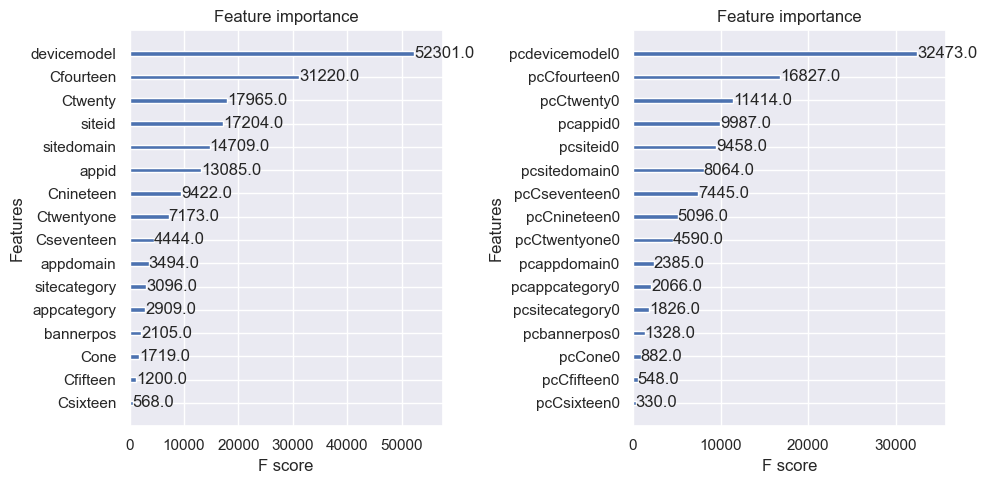

In [ ]:
# 26.6 pc0 columns vs cat columns importance

fix,ax = plt.subplots(nrows =1, ncols=2, figsize = (10,5))
_=xgb.plot_importance(model_orig_few, ax = ax[0])
# 25.1 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_vec_pc0, ax = ax[1])
plt.tight_layout()

### Undersampling of unitvectors pc0s columns

In [ ]:
# 27.0 Call imblearn library:
#       We find EditedNearestNeighbours the best in this case

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

In [ ]:
# 27.0.1 Columns containing only Ist PCs:

pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)
len(pc0cols)  # 12

In [ ]:
# 27.1 Undersample/cleanup unitvectors datawith only pc0s:

undersample = EditedNearestNeighbours()
X_res_pc0, y_res_pc0 = undersample.fit_resample(cctr[pc0cols], y_train.values)


# 27.1.1 Data shape
X_res_pc0.shape  #  (3737267, 5)
y_res_pc0.shape  #  (3737267,)

11761

(1077147, 16)

(1077147,)

In [ ]:
# 27.1.2 Save above files:

X_res_pc0.to_pickle(avazudata / "X_res_pc0.pkl")
y_res_pc0 = pd.DataFrame(y_res_pc0, columns= [ 'click'])
y_res_pc0.to_pickle(avazudata / "y_res_pc0.pkl")
gc.collect()

0

In [ ]:
# 27.1.3 Read back:

X_res_pc0 = pd.read_pickle(avazudata / "X_res_pc0.pkl")
y_res_pc0 = pd.read_pickle(avazudata / "y_res_pc0.pkl")
y_res_pc0.value_counts(normalize = True) # 76:23
y_train.value_counts(normalize = True) # 83:17

click
0        0.763002
1        0.236998
dtype: float64

0    0.829778
1    0.170222
Name: click, dtype: float64

In [ ]:
# 27.2 xgboost Modeling with undersampled data:

model_res_pc0 = xgb.XGBClassifier( n_estimators= 400,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_pc0
test_X = ccte[pc0cols]
ytrain = y_res_pc0
ytest =  y_test


model_res_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )

0

[18:22:46] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:22:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1100 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.78669	validation_1-auc:0.68693
[18:22:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1076 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.79300	validation_1-auc:0.69041
[18:22:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1080 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.79433	validation_1-auc:0.69190
[18:22:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1106 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.79656	vali

[18:23:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 990 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.82186	validation_1-auc:0.71590
[18:23:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1034 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.82255	validation_1-auc:0.71645
[18:23:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 982 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.82331	validation_1-auc:0.71708
[18:23:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1020 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.82382	validation_1-auc:0.71735
[18:23:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune

[18:23:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1074 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.83619	validation_1-auc:0.72524
[18:23:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1026 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.83654	validation_1-auc:0.72547
[18:23:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 642 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.83665	validation_1-auc:0.72556
[18:23:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 730 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.83686	validation_1-auc:0.72557
[18:23:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune

[109]	validation_0-auc:0.84558	validation_1-auc:0.72763
[18:23:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 904 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.84574	validation_1-auc:0.72766
[18:23:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1170 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.84604	validation_1-auc:0.72766
[18:23:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 708 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.84624	validation_1-auc:0.72776
[18:23:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1084 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.84643	validation_1-auc:0.72777
[18:23:48] INFO: C:\Users\dev-admin\cr

[18:24:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 896 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.85258	validation_1-auc:0.72852
[18:24:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1162 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.85283	validation_1-auc:0.72847
[18:24:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 626 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.85298	validation_1-auc:0.72853
[18:24:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.85300	validation_1-auc:0.72852
[18:24:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[182]	validation_0-auc:0.85652	validation_1-auc:0.72887
[18:24:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.85657	validation_1-auc:0.72888
[18:24:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 644 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.85665	validation_1-auc:0.72887
[18:24:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1390 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.85688	validation_1-auc:0.72892
[18:24:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 830 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.85701	validation_1-auc:0.72893
[18:24:27] INFO: C:\Users\dev-admin\cro

[18:24:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 962 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.86081	validation_1-auc:0.72880
[18:24:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 908 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.86095	validation_1-auc:0.72881
[18:24:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.86097	validation_1-auc:0.72881
[18:24:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1016 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.86112	validation_1-auc:0.72885
[18:24:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[255]	validation_0-auc:0.86469	validation_1-auc:0.72846
[18:25:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.86473	validation_1-auc:0.72846
[18:25:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.86474	validation_1-auc:0.72847
[18:25:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1156 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.86492	validation_1-auc:0.72845
[18:25:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.86493	validation_1-auc:0.72845
[18:25:05] INFO: C:\Users\dev-admin\cro

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 27.2.1 Save model:

utils.savePythonObject(model_res_pc0, "model_res_pc0.pkl", avazuestimators )

Object saved to: c:\avazu\allmodels\estimators\model_res_pc0.pkl


In [ ]:
# 27.2.2 Restore model:

model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", avazuestimators )

In [ ]:
# 27.2.3 Best scores:

model_res_pc0.best_score   # 0.7352568578802253
print("\n")
model_res_pc0.best_iteration  # 139

0.7289305732606125

186

In [ ]:
# 27.2.4 Classification report:

pred_vec = model_res_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88    414806
           1       0.37      0.31      0.34     85094

    accuracy                           0.79    499900
   macro avg       0.62      0.60      0.61    499900
weighted avg       0.78      0.79      0.79    499900



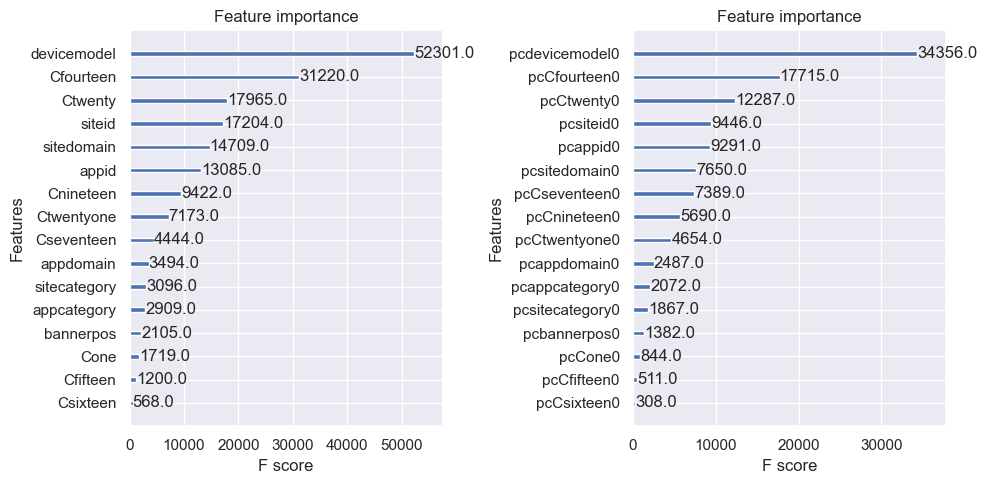

In [ ]:
# 27.2.5 Comparing xgboost feature importance, once again:
#  Original data vs univectors data with just pc0s

fix,ax = plt.subplots(nrows =1, ncols=2, figsize = (10,5))
_=xgb.plot_importance(model_orig_few, ax = ax[0])

# 27.2.6 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_res_pc0, ax = ax[1])
plt.tight_layout()

### Density plots
Almost a) the same xgboost feature importance rankings, b) almost the same AUC scores and c) same classification reports,  between the original data (having discrete features) and in unitvectors (pc0s) data (having continuous features), points towards one-to-one relationships between the discrete features and the corresponding continupos features.  

To understand discrete features better, we can draw density plots of corresponding continuous features.

In [ ]:
## Density plots
# 28.0 Read back cctr/ccte
cctr = pd.read_pickle(avazuunitvecs  / "cctr.pkl")

In [ ]:
# 28.1
pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)

['pcCone0', 'pcbannerpos0', 'pcsiteid0', 'pcsitedomain0', 'pcsitecategory0', 'pcappid0', 'pcappdomain0', 'pcappcategory0', 'pcdevicemodel0', 'pcCfourteen0', 'pcCfifteen0', 'pcCsixteen0', 'pcCseventeen0', 'pcCnineteen0', 'pcCtwenty0', 'pcCtwentyone0']


In [ ]:
# 28.2
cctr['target']= y_train.reset_index(drop = True)

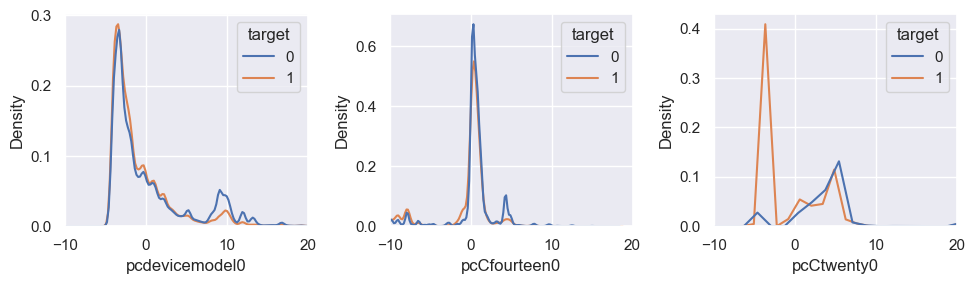

In [ ]:
# 28.3
# https://stackoverflow.com/a/42734379
# https://stackoverflow.com/a/63895570

fig,ax = plt.subplots(nrows = 1,ncols = 3, figsize = (10,3))

_=sns.kdeplot(cctr,
              x="pcdevicemodel0",
              hue="target",
              ax = ax[0],
              common_norm = False)
_=ax[0].set_xlim(-10, 20)

_=sns.kdeplot(cctr,
              x="pcCfourteen0",
              hue="target",
              ax = ax[1],
              common_norm = False)
_=ax[1].set_xlim(-10, 20)

_=sns.kdeplot(cctr,
              x="pcCtwenty0",
              hue="target",
              ax = ax[2],
              common_norm = False)
_=ax[2].set_xlim(-10, 20)

plt.tight_layout()



In [ ]:
# 28.4 Take a sample of cctr for contour plots between two features:

_, cc_test, _ , y_cc_test = train_test_split(
                                              cctr,
                                              y_train,
                                              test_size = 0.25,
                                              stratify= y_train,
                                              random_state= rng)


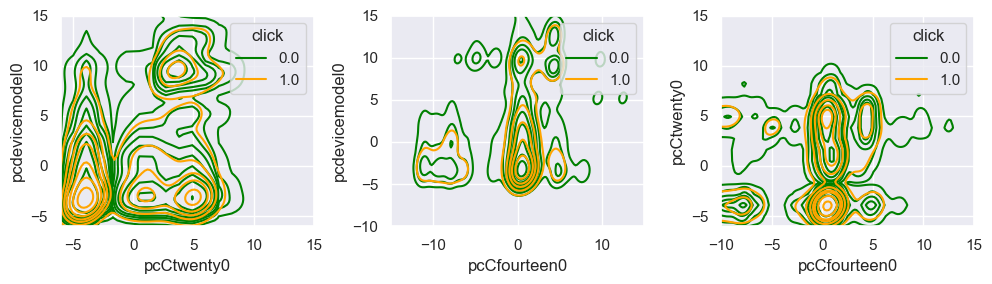

In [ ]:
# 28.5 Contour plots of two-features at a time
#      First three impt features are considered

fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize=(10,3))
_= sns.kdeplot(data=cc_test,
               x="pcCtwenty0",
               y = "pcdevicemodel0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
               ax = ax[0])
_=ax[0].set_xlim(-6, 15)
_=ax[0].set_ylim(-6, 15)

_= sns.kdeplot(data=cc_test,
               x="pcCfourteen0",
               y = "pcdevicemodel0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
              ax = ax[1])
_=ax[1].set_xlim(-15, 15)
_=ax[1].set_ylim(-10, 15)

_= sns.kdeplot(data=cc_test,
               x="pcCfourteen0",
               y = "pcCtwenty0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
               ax = ax[2])
_=ax[2].set_xlim(-15, 15)
_=ax[2].set_ylim(-10, 14)
plt.tight_layout()

## A Summary-- an Overall comparative picture

### Readback limited stored data

In [ ]:
# 29.0
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 29.1   Reindex X_train/X_test for concatenation
#        of cat cols to be possible with transformed data
X_test = X_test.reset_index(drop = True)




# 29.2 Our list of cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols



# 29.3 Remaining cols not treated as cat cols:
rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols

# 29.4 Concat rem_cols with transformed data:
#      Columns after transformeation to be considered. Ignore initial cat_cols
transcols = test_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate (exclude device_id and device):
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)


# 13.2.1 Read back saved imputed data:

X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")


# 14.1 Read back saved data:

pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 24.0 Read back cctr/ccte
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")
# 24.1 Columns containing only Ist PCs:
pc0cols = [i for i in ccte.columns if '0' in i]
Xte = X_test.copy()
_=Xte.pop('deviceid')
_=Xte.pop('deviceip')

pccols = ['devicemodel','Cfourteen','Ctwenty','appid','siteid','sitedomain',
          'Cseventeen','Cnineteen','Ctwentyone','appdomain','sitecategory','appcategory']


### Readback models

In [ ]:
# Model with original data
model_orig = utils.restorePythonObject("model_orig.pkl", avazudata )

# Model with transformed data
model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)


#Model with original data but without deviceid and deviceip
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

# Model with important transfomed features
model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

# Get important features
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)

# Model with 95% pca of transformed features
model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

# Model after EditedNearestNeighbours on 95% pca data
model_en = utils.restorePythonObject("model_en.pkl", avazudata)

# Model after smoteenn on 95% pca data
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

# Model with only unitvectors data
model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

# Model with original data but with with those columns whose unitvectors are available
model_orig_few = utils.restorePythonObject("model_orig_few.pkl", avazudata)

# 24.4 Model with pc0 columns of unitvectors
model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", avazuestimators  )

# Model after EditedNearestNeighbours on pc0 columns of unitvectors
model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", avazuestimators )


### Results

In [ ]:
# 35.0 An all inclusive comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
re6 = []
re7 = []
re8 = []
re9 = []
re10 = []
cols = ['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']
table = [re1,re2,re3,re4,re5,re6,re7,re8,re9]

# 35.1 Predictions
p1 = model_orig.predict(X_test)
p2=  model_trans.predict(X_test_trans)
p3 = model_orig_noip.predict(Xte)
p4 = model_trans_impt.predict(X_test_trans[fe_1])
p5 = model_pca.predict(pca_test)
p6 = model_en.predict(pca_test)
p7 = model_sm.predict(pca_test)
p8 = model_vec.predict(ccte)
p9 = model_vec_pc0.predict(ccte[pc0cols])
p10 = model_orig_few.predict(X_test[pccols])


# 35.2 Dataframe Index
str1 = "Modeling with orig data"
str2 = "Modeling with transformed data (no deviceid/deviceip)"
str3 = "Modeling with orig data (no deviceid/deviceip)"
str4 = "Modeling with impt transformed features"
str5 = "Modeling with PCAs of transformed data"
str6 = "PCA data cleaned up with EditedNearestNeighbours"
str7 = "PCA data cleaned up with SMOTEENN"
str8 = "Modeling with unitvectors data"
str9 = "Modeling with unitvectors data--only pc0s"
str10 = "Modeling with orig data but for which univectors exist"

# 35.3
re1.append(str1)
re2.append(str2)
re3.append(str3)
re4.append(str4)
re5.append(str5)
re6.append(str6)
re7.append(str7)
re8.append(str8 )
re9.append(str9)
re10.append(str10)


# 35.4 AUC first
s1 = model_orig.best_score
s2=  model_trans.best_score
s3 = model_orig_noip.best_score
s4 = model_trans_impt.best_score
s5 = model_pca.best_score
s6 = model_en.best_score
s7 = model_sm.best_score
s8 = model_vec.best_score
s9 = model_res_pc0.best_score
s10 = model_orig_few.best_score

# 35.5
re1.append(s1)
re2.append(s2 )
re3.append(s3)
re4.append(s4)
re5.append(s5)
re6.append(s6)
re7.append(s7)
re8.append(s8)
re9.append(s9)
re10.append(s10)

# 35.6
f1 = f1_score(y_test.values, p1)
f2 = f1_score(y_test.values, p2)
f3 = f1_score(y_test.values, p3)
f4 = f1_score(y_test.values, p4)
f5 = f1_score(y_test.values, p5)
f6 = f1_score(y_test.values, p6)
f7 = f1_score(y_test.values, p7)
f8 = f1_score(y_test.values, p8)
f9 = f1_score(y_test.values, p9)
f10 = f1_score(y_test.values, p10)

# 35.7
re1.append(f1)
re2.append(f2)
re3.append(f3)
re4.append(f4)
re5.append(f5)
re6.append(f6)
re7.append(f7)
re8.append(f8)
re9.append(f9)
re10.append(f10)

# 35.8 kappa score
k1 = cohen_kappa_score(y_test.values,p1)
k2 = cohen_kappa_score(y_test.values,p2)
k3 = cohen_kappa_score(y_test.values,p3)
k4 = cohen_kappa_score(y_test.values,p4)
k5 = cohen_kappa_score(y_test.values,p5)
k6 = cohen_kappa_score(y_test.values,p6)
k7 = cohen_kappa_score(y_test.values,p7)
k8 = cohen_kappa_score(y_test.values,p8)
k9 = cohen_kappa_score(y_test.values,p9)
k10 = cohen_kappa_score(y_test.values,p10)

# 35.9
re1.append(k1)
re2.append(k2)
re3.append(k3)
re4.append(k4)
re5.append(k5)
re6.append(k6)
re7.append(k7)
re8.append(k8)
re9.append(k9)
re10.append(k10)


# 35.10 Accuracy score
a1 = accuracy_score(y_test.values,p1)
a2 = accuracy_score(y_test.values,p2)
a3 = accuracy_score(y_test.values,p3)
a4 = accuracy_score(y_test.values,p4)
a5 = accuracy_score(y_test.values,p5)
a6 = accuracy_score(y_test.values,p6)
a7 = accuracy_score(y_test.values,p7)
a8 = accuracy_score(y_test.values,p8)
a9 = accuracy_score(y_test.values,p9)
a10 = accuracy_score(y_test.values,p10)


# Matthews correlation Coef

# 35.8 Matthew correlation Coeff
m1 = matthews_corrcoef(y_test.values,p1)
m2 = matthews_corrcoef(y_test.values,p2)
m3 = matthews_corrcoef(y_test.values,p3)
m4 = matthews_corrcoef(y_test.values,p4)
m5 = matthews_corrcoef(y_test.values,p5)
m6 = matthews_corrcoef(y_test.values,p6)
m7 = matthews_corrcoef(y_test.values,p7)
m8 = matthews_corrcoef(y_test.values,p8)
m9 = matthews_corrcoef(y_test.values,p9)
m10 = matthews_corrcoef(y_test.values,p10)



# 35.11
re1.append(a1)
re2.append(a2)
re3.append(a3)
re4.append(a4)
re5.append(a5)
re6.append(a6)
re7.append(a7)
re8.append(a8)
re9.append(a9)
re10.append(a10)

In [ ]:
# 36.0 Print table now
out = pd.DataFrame({"AUC score": [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10] ,
                   "f1 score" : [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10],
                   "kappa score" : [k1,k2,k3,k4,k5,k6,k7,k8,k9,k10],
                   "accuracy" : [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10],
                   "Matthews Cor Coef" : [m1,m2,m3,m4,m5,m6,m7,m8,m9,m10]
                   },

                    index = [str1,str2,str3,str4,str5,str6,str7,str8,str9,str10])

print(f"\n               lightorange is min of column and lightgreen is max of a columns")
out.style.\
highlight_min(color = 'orange', axis = 0).\
highlight_max(color = 'lightgreen', axis = 0)


               lightorange is min of column and lightgreen is max of a columns


,AUC score,f1 score,kappa score,accuracy,Matthews Cor Coef
Modeling with orig data,0.749783,0.153388,0.114899,0.834995,0.182878
Modeling with transformed data (no deviceid/deviceip),0.752567,0.159266,0.119726,0.835345,0.187763
Modeling with orig data (no deviceid/deviceip),0.750052,0.159395,0.119038,0.834871,0.185021
Modeling with impt transformed features,0.752381,0.159908,0.119927,0.835185,0.187110
Modeling with PCAs of transformed data,0.737825,0.143429,0.105836,0.833863,0.171080
PCA data cleaned up with EditedNearestNeighbours,0.738499,0.367625,0.240096,0.787713,0.240124
PCA data cleaned up with SMOTEENN,0.730988,0.402376,0.208824,0.637666,0.256706
Modeling with unitvectors data,0.745940,0.139882,0.105751,0.835317,0.178748
Modeling with unitvectors data--only pc0s,0.735257,0.124922,0.094008,0.834669,0.167423
Modeling with orig data but for which univectors exist,0.748781,0.148389,0.111839,0.835317,0.182573


In [ ]:
# Add labels to bar chart
# Ref: https://stackoverflow.com/a/48372659/3282777

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

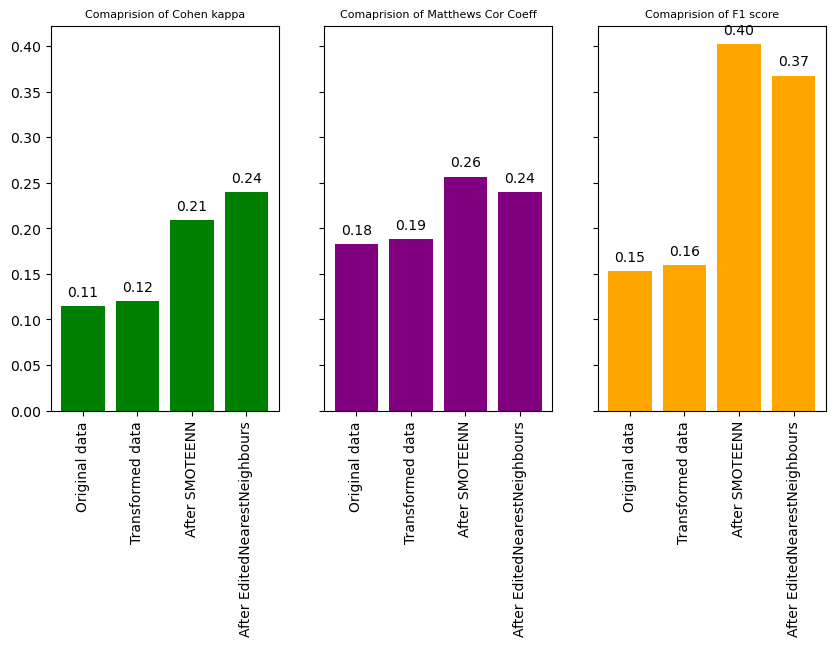

In [ ]:
# Combined plots:
plt.style.use('default')
fig,ax = plt.subplots(1,3,sharey = True, figsize= (10,5))
xlabels = ['Original data', 'Transformed data', 'After SMOTEENN', 'After EditedNearestNeighbours']
yvalues_ck = [k1,k2,k7,k6]
yvalues_mcc = [m1,m2,m7,m6]
yvalues_f1 = [f1,f2,f7,f6]
ax[0].bar(xlabels,yvalues_ck,color = 'green');
ax[1].bar(xlabels,yvalues_mcc, color = 'purple');
ax[2].bar(xlabels,yvalues_f1, color = 'orange');
ax[0].set_xticklabels(xlabels, rotation=90)
ax[1].set_xticklabels(xlabels, rotation=90)
ax[2].set_xticklabels(xlabels, rotation=90)
ax[0].set_title("Comaprision of Cohen kappa", fontsize = 8)
ax[1].set_title("Comaprision of Matthews Cor Coeff", fontsize = 8)
ax[2].set_title("Comaprision of F1 score", fontsize = 8)
add_value_labels(ax[0])
add_value_labels(ax[1])
add_value_labels(ax[2])
plt.show();

## Some more experiments
Feature Engineering with clustering


In [ ]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 10,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24
Current index:  28
Current index:  32
Current index:  36
Current index:  40
Current index:  44


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,2.889698,-0.597556,-0.605230,-0.983609,5.770558,-0.088779,0.976720,-0.682658,-6.472119,1.824779,...,1,0,1,0,8,0,1,5,5,2
1,-6.821252,-0.074456,0.273082,0.473605,-6.375553,-0.859748,0.679954,0.400250,1.803573,-2.779584,...,2,2,4,2,0,8,8,9,7,2
2,-6.821253,-0.073874,0.302884,0.500631,-6.375553,-0.859665,0.707247,0.438487,1.803671,-2.779428,...,2,2,4,1,0,3,0,5,1,2


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,5.327249,1.232158,0.846737,0.695078,-2.509640,3.133112,-2.559268,-0.610693,-6.472470,1.827506,...,1,0,1,0,0,0,9,0,1,5
1,-6.821211,-0.073856,0.303019,0.497530,-6.375741,-0.859648,0.703604,0.442896,1.803659,-2.779504,...,2,1,4,1,0,3,5,1,1,6
2,4.224539,-1.295526,-1.220209,-0.389639,6.814605,-0.838232,0.547893,-1.040711,2.012367,-0.608370,...,3,0,1,0,1,2,5,7,1,6


In [ ]:
# 25.2 Have a look at clusters created:
gc.collect()
colNames = [i for i in fe_tr.columns if "clu" in i]

fe_tr[colNames].head()
fe_te[colNames].head()


0

,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,7,1,1,0,1,0,8,0,1,5,5,2
1,0,0,2,2,4,2,0,8,8,9,7,2
2,0,0,2,2,4,1,0,3,0,5,1,2
3,1,3,0,0,1,0,0,4,3,5,0,3
4,0,0,2,2,5,1,8,2,1,7,1,5


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,1,2,1,0,1,0,0,0,9,0,1,5
1,0,0,2,1,4,1,0,3,5,1,1,6
2,2,1,3,0,1,0,1,2,5,7,1,6
3,2,1,3,0,1,0,8,2,5,1,1,5
4,0,0,2,2,3,1,0,2,1,1,1,2


In [ ]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 2000,
                              verbosity = 3,
                              eta = 0.1,
                              max_depth = 6,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )

tr_X =   fe_tr[colNames]
test_X =  fe_te[colNames]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 200,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[18:21:24] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:21:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.66579	validation_1-auc:0.66534
[18:21:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.66725	validation_1-auc:0.66664
[18:21:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.67263	validation_1-auc:0.67181
[18:21:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.67804	validation_1

[36]	validation_0-auc:0.70236	validation_1-auc:0.70165
[18:21:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[37]	validation_0-auc:0.70274	validation_1-auc:0.70203
[18:21:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[38]	validation_0-auc:0.70356	validation_1-auc:0.70287
[18:21:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[39]	validation_0-auc:0.70373	validation_1-auc:0.70302
[18:21:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[40]	validation_0-auc:0.70408	validation_1-auc:0.70336
[18:21:47] INFO: C:\Users\dev-admin\croot2\xgboos

[73]	validation_0-auc:0.71285	validation_1-auc:0.71178
[18:22:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[74]	validation_0-auc:0.71305	validation_1-auc:0.71197
[18:22:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[75]	validation_0-auc:0.71341	validation_1-auc:0.71234
[18:22:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[76]	validation_0-auc:0.71374	validation_1-auc:0.71264
[18:22:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[77]	validation_0-auc:0.71387	validation_1-auc:0.71277
[18:22:07] INFO: C:\Users\dev-admin\croot2\xgboos

[110]	validation_0-auc:0.71828	validation_1-auc:0.71682
[18:22:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[111]	validation_0-auc:0.71844	validation_1-auc:0.71697
[18:22:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[112]	validation_0-auc:0.71847	validation_1-auc:0.71699
[18:22:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[113]	validation_0-auc:0.71849	validation_1-auc:0.71702
[18:22:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[114]	validation_0-auc:0.71859	validation_1-auc:0.71711
[18:22:28] INFO: C:\Users\dev-admin\croot2\x

[147]	validation_0-auc:0.72114	validation_1-auc:0.71919
[18:22:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[148]	validation_0-auc:0.72120	validation_1-auc:0.71923
[18:22:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[149]	validation_0-auc:0.72129	validation_1-auc:0.71931
[18:22:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[150]	validation_0-auc:0.72133	validation_1-auc:0.71933
[18:22:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[151]	validation_0-auc:0.72138	validation_1-auc:0.71937
[18:22:48] INFO: C:\Users\dev-admin\croot2\x

[184]	validation_0-auc:0.72322	validation_1-auc:0.72082
[18:23:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[185]	validation_0-auc:0.72324	validation_1-auc:0.72084
[18:23:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[186]	validation_0-auc:0.72329	validation_1-auc:0.72087
[18:23:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[187]	validation_0-auc:0.72335	validation_1-auc:0.72093
[18:23:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[188]	validation_0-auc:0.72345	validation_1-auc:0.72100
[18:23:09] INFO: C:\Users\dev-admin\croot2\x

[221]	validation_0-auc:0.72467	validation_1-auc:0.72184
[18:23:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[222]	validation_0-auc:0.72472	validation_1-auc:0.72187
[18:23:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[223]	validation_0-auc:0.72476	validation_1-auc:0.72190
[18:23:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[224]	validation_0-auc:0.72481	validation_1-auc:0.72196
[18:23:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[225]	validation_0-auc:0.72485	validation_1-auc:0.72198
[18:23:29] INFO: C:\Users\dev-admin\croot2\x

[258]	validation_0-auc:0.72575	validation_1-auc:0.72266
[18:23:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[259]	validation_0-auc:0.72575	validation_1-auc:0.72266
[18:23:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[260]	validation_0-auc:0.72578	validation_1-auc:0.72268
[18:23:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[261]	validation_0-auc:0.72580	validation_1-auc:0.72269
[18:23:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[262]	validation_0-auc:0.72585	validation_1-auc:0.72274
[18:23:50] INFO: C:\Users\dev-admin\croot2\x

[295]	validation_0-auc:0.72671	validation_1-auc:0.72326
[18:24:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[296]	validation_0-auc:0.72673	validation_1-auc:0.72327
[18:24:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[297]	validation_0-auc:0.72676	validation_1-auc:0.72328
[18:24:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[298]	validation_0-auc:0.72679	validation_1-auc:0.72331
[18:24:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[299]	validation_0-auc:0.72682	validation_1-auc:0.72332
[18:24:11] INFO: C:\Users\dev-admin\croot2\x

[332]	validation_0-auc:0.72749	validation_1-auc:0.72368
[18:24:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[333]	validation_0-auc:0.72751	validation_1-auc:0.72368
[18:24:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[334]	validation_0-auc:0.72754	validation_1-auc:0.72370
[18:24:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[335]	validation_0-auc:0.72756	validation_1-auc:0.72372
[18:24:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[336]	validation_0-auc:0.72757	validation_1-auc:0.72370
[18:24:31] INFO: C:\Users\dev-admin\croot2\xg

[369]	validation_0-auc:0.72820	validation_1-auc:0.72409
[18:24:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[370]	validation_0-auc:0.72821	validation_1-auc:0.72409
[18:24:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[371]	validation_0-auc:0.72823	validation_1-auc:0.72410
[18:24:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[372]	validation_0-auc:0.72824	validation_1-auc:0.72410
[18:24:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[373]	validation_0-auc:0.72827	validation_1-auc:0.72410
[18:24:52] INFO: C:\Users\dev-admin\croot2\xg

[406]	validation_0-auc:0.72867	validation_1-auc:0.72432
[18:25:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[407]	validation_0-auc:0.72868	validation_1-auc:0.72431
[18:25:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[408]	validation_0-auc:0.72869	validation_1-auc:0.72431
[18:25:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[409]	validation_0-auc:0.72870	validation_1-auc:0.72432
[18:25:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[410]	validation_0-auc:0.72871	validation_1-auc:0.72433
[18:25:12] INFO: C:\Users\dev-admin\croot2\xg

[443]	validation_0-auc:0.72913	validation_1-auc:0.72451
[18:25:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[444]	validation_0-auc:0.72914	validation_1-auc:0.72450
[18:25:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[445]	validation_0-auc:0.72915	validation_1-auc:0.72451
[18:25:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[446]	validation_0-auc:0.72917	validation_1-auc:0.72453
[18:25:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[447]	validation_0-auc:0.72918	validation_1-auc:0.72453
[18:25:33] INFO: C:\Users\dev-admin\croot2\x

[480]	validation_0-auc:0.72957	validation_1-auc:0.72468
[18:25:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[481]	validation_0-auc:0.72959	validation_1-auc:0.72469
[18:25:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[482]	validation_0-auc:0.72961	validation_1-auc:0.72469
[18:25:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[483]	validation_0-auc:0.72961	validation_1-auc:0.72470
[18:25:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[484]	validation_0-auc:0.72962	validation_1-auc:0.72470
[18:25:54] INFO: C:\Users\dev-admin\croot2\xg

[517]	validation_0-auc:0.72999	validation_1-auc:0.72486
[18:26:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[518]	validation_0-auc:0.72999	validation_1-auc:0.72487
[18:26:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[519]	validation_0-auc:0.73001	validation_1-auc:0.72488
[18:26:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[520]	validation_0-auc:0.73003	validation_1-auc:0.72489
[18:26:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[521]	validation_0-auc:0.73004	validation_1-auc:0.72489
[18:26:14] INFO: C:\Users\dev-admin\croot2\x

[554]	validation_0-auc:0.73035	validation_1-auc:0.72501
[18:26:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[555]	validation_0-auc:0.73037	validation_1-auc:0.72503
[18:26:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[556]	validation_0-auc:0.73038	validation_1-auc:0.72502
[18:26:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[557]	validation_0-auc:0.73038	validation_1-auc:0.72503
[18:26:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[558]	validation_0-auc:0.73038	validation_1-auc:0.72502
[18:26:35] INFO: C:\Users\dev-admin\croot2\xgb

[591]	validation_0-auc:0.73069	validation_1-auc:0.72511
[18:26:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[592]	validation_0-auc:0.73070	validation_1-auc:0.72511
[18:26:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[593]	validation_0-auc:0.73071	validation_1-auc:0.72511
[18:26:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[594]	validation_0-auc:0.73072	validation_1-auc:0.72511
[18:26:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[595]	validation_0-auc:0.73073	validation_1-auc:0.72512
[18:26:55] INFO: C:\Users\dev-admin\croot2\x

[628]	validation_0-auc:0.73097	validation_1-auc:0.72521
[18:27:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[629]	validation_0-auc:0.73098	validation_1-auc:0.72522
[18:27:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[630]	validation_0-auc:0.73099	validation_1-auc:0.72522
[18:27:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[631]	validation_0-auc:0.73100	validation_1-auc:0.72522
[18:27:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[632]	validation_0-auc:0.73100	validation_1-auc:0.72522
[18:27:16] INFO: C:\Users\dev-admin\croot2\x

[665]	validation_0-auc:0.73129	validation_1-auc:0.72527
[18:27:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[666]	validation_0-auc:0.73129	validation_1-auc:0.72527
[18:27:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[667]	validation_0-auc:0.73130	validation_1-auc:0.72528
[18:27:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[668]	validation_0-auc:0.73131	validation_1-auc:0.72529
[18:27:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[669]	validation_0-auc:0.73132	validation_1-auc:0.72529
[18:27:36] INFO: C:\Users\dev-admin\croot2\x

[702]	validation_0-auc:0.73156	validation_1-auc:0.72535
[18:27:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[703]	validation_0-auc:0.73156	validation_1-auc:0.72535
[18:27:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[704]	validation_0-auc:0.73157	validation_1-auc:0.72535
[18:27:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[705]	validation_0-auc:0.73158	validation_1-auc:0.72535
[18:27:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[706]	validation_0-auc:0.73158	validation_1-auc:0.72535
[18:27:57] INFO: C:\Users\dev-admin\croot2\xg

[739]	validation_0-auc:0.73183	validation_1-auc:0.72543
[18:28:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[740]	validation_0-auc:0.73184	validation_1-auc:0.72543
[18:28:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[741]	validation_0-auc:0.73184	validation_1-auc:0.72542
[18:28:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[742]	validation_0-auc:0.73184	validation_1-auc:0.72543
[18:28:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[743]	validation_0-auc:0.73185	validation_1-auc:0.72543
[18:28:17] INFO: C:\Users\dev-admin\croot2\x

[776]	validation_0-auc:0.73205	validation_1-auc:0.72549
[18:28:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[777]	validation_0-auc:0.73205	validation_1-auc:0.72549
[18:28:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[778]	validation_0-auc:0.73207	validation_1-auc:0.72550
[18:28:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[779]	validation_0-auc:0.73207	validation_1-auc:0.72550
[18:28:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[780]	validation_0-auc:0.73208	validation_1-auc:0.72550
[18:28:38] INFO: C:\Users\dev-admin\croot2\x

[813]	validation_0-auc:0.73231	validation_1-auc:0.72557
[18:28:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[814]	validation_0-auc:0.73231	validation_1-auc:0.72556
[18:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[815]	validation_0-auc:0.73232	validation_1-auc:0.72556
[18:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[816]	validation_0-auc:0.73232	validation_1-auc:0.72557
[18:28:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[817]	validation_0-auc:0.73232	validation_1-auc:0.72557
[18:28:58] INFO: C:\Users\dev-admin\croot2\x

[850]	validation_0-auc:0.73250	validation_1-auc:0.72560
[18:29:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[851]	validation_0-auc:0.73251	validation_1-auc:0.72560
[18:29:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[852]	validation_0-auc:0.73251	validation_1-auc:0.72560
[18:29:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[853]	validation_0-auc:0.73252	validation_1-auc:0.72560
[18:29:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[854]	validation_0-auc:0.73252	validation_1-auc:0.72561
[18:29:19] INFO: C:\Users\dev-admin\croot2\x

[887]	validation_0-auc:0.73268	validation_1-auc:0.72562
[18:29:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[888]	validation_0-auc:0.73268	validation_1-auc:0.72562
[18:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[889]	validation_0-auc:0.73269	validation_1-auc:0.72563
[18:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[890]	validation_0-auc:0.73270	validation_1-auc:0.72563
[18:29:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[891]	validation_0-auc:0.73270	validation_1-auc:0.72563
[18:29:39] INFO: C:\Users\dev-admin\croot2\xg

[924]	validation_0-auc:0.73287	validation_1-auc:0.72568
[18:29:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[925]	validation_0-auc:0.73288	validation_1-auc:0.72567
[18:29:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[926]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:29:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[927]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:29:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[928]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:30:00] INFO: C:\Users\dev-admin\croot2\x

[961]	validation_0-auc:0.73305	validation_1-auc:0.72571
[18:30:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[962]	validation_0-auc:0.73305	validation_1-auc:0.72572
[18:30:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[963]	validation_0-auc:0.73305	validation_1-auc:0.72572
[18:30:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[964]	validation_0-auc:0.73306	validation_1-auc:0.72573
[18:30:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[965]	validation_0-auc:0.73306	validation_1-auc:0.72572
[18:30:21] INFO: C:\Users\dev-admin\croot2\xg

[998]	validation_0-auc:0.73322	validation_1-auc:0.72575
[18:30:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[999]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[1000]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1001]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[1002]	validation_0-auc:0.73324	validation_1-auc:0.72574
[18:30:41] INFO: C:\Users\dev-admin\croot2\

[1035]	validation_0-auc:0.73339	validation_1-auc:0.72578
[18:31:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1036]	validation_0-auc:0.73340	validation_1-auc:0.72577
[18:31:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1037]	validation_0-auc:0.73340	validation_1-auc:0.72578
[18:31:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1038]	validation_0-auc:0.73341	validation_1-auc:0.72578
[18:31:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1039]	validation_0-auc:0.73341	validation_1-auc:0.72578
[18:31:02] INFO: C:\Users\dev-admin\cro

[1072]	validation_0-auc:0.73355	validation_1-auc:0.72581
[18:31:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1073]	validation_0-auc:0.73356	validation_1-auc:0.72581
[18:31:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1074]	validation_0-auc:0.73356	validation_1-auc:0.72581
[18:31:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1075]	validation_0-auc:0.73357	validation_1-auc:0.72581
[18:31:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1076]	validation_0-auc:0.73357	validation_1-auc:0.72581
[18:31:22] INFO: C:\Users\dev-admin\croo

[1109]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1110]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[1111]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1112]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1113]	validation_0-auc:0.73372	validation_1-auc:0.72586
[18:31:43] INFO: C:\Users\dev-admin\croo

[1146]	validation_0-auc:0.73384	validation_1-auc:0.72589
[18:32:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1147]	validation_0-auc:0.73384	validation_1-auc:0.72589
[18:32:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1148]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1149]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1150]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:04] INFO: C:\Users\dev-admin\cro

[1183]	validation_0-auc:0.73396	validation_1-auc:0.72591
[18:32:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1184]	validation_0-auc:0.73396	validation_1-auc:0.72591
[18:32:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1185]	validation_0-auc:0.73397	validation_1-auc:0.72592
[18:32:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[1186]	validation_0-auc:0.73397	validation_1-auc:0.72592
[18:32:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1187]	validation_0-auc:0.73398	validation_1-auc:0.72592
[18:32:24] INFO: C:\Users\dev-admin\cro

[1220]	validation_0-auc:0.73411	validation_1-auc:0.72595
[18:32:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[1221]	validation_0-auc:0.73411	validation_1-auc:0.72594
[18:32:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1222]	validation_0-auc:0.73411	validation_1-auc:0.72595
[18:32:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1223]	validation_0-auc:0.73412	validation_1-auc:0.72595
[18:32:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1224]	validation_0-auc:0.73412	validation_1-auc:0.72595
[18:32:45] INFO: C:\Users\dev-admin\croo

[1257]	validation_0-auc:0.73424	validation_1-auc:0.72598
[18:33:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[1258]	validation_0-auc:0.73424	validation_1-auc:0.72598
[18:33:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[1259]	validation_0-auc:0.73425	validation_1-auc:0.72598
[18:33:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1260]	validation_0-auc:0.73425	validation_1-auc:0.72599
[18:33:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1261]	validation_0-auc:0.73425	validation_1-auc:0.72598
[18:33:05] INFO: C:\Users\dev-admin\croot

[1294]	validation_0-auc:0.73437	validation_1-auc:0.72596
[18:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1295]	validation_0-auc:0.73437	validation_1-auc:0.72595
[18:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1296]	validation_0-auc:0.73437	validation_1-auc:0.72596
[18:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1297]	validation_0-auc:0.73438	validation_1-auc:0.72596
[18:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1298]	validation_0-auc:0.73438	validation_1-auc:0.72595
[18:33:26] INFO: C:\Users\dev-admin\cro

[1331]	validation_0-auc:0.73449	validation_1-auc:0.72598
[18:33:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1332]	validation_0-auc:0.73449	validation_1-auc:0.72598
[18:33:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1333]	validation_0-auc:0.73450	validation_1-auc:0.72598
[18:33:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1334]	validation_0-auc:0.73450	validation_1-auc:0.72598
[18:33:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1335]	validation_0-auc:0.73451	validation_1-auc:0.72598
[18:33:47] INFO: C:\Users\dev-admin\cro

[1368]	validation_0-auc:0.73461	validation_1-auc:0.72599
[18:34:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1369]	validation_0-auc:0.73461	validation_1-auc:0.72599
[18:34:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1370]	validation_0-auc:0.73462	validation_1-auc:0.72599
[18:34:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1371]	validation_0-auc:0.73462	validation_1-auc:0.72599
[18:34:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[1372]	validation_0-auc:0.73463	validation_1-auc:0.72599
[18:34:07] INFO: C:\Users\dev-admin\croo

[1405]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1406]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1407]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1408]	validation_0-auc:0.73472	validation_1-auc:0.72604
[18:34:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1409]	validation_0-auc:0.73473	validation_1-auc:0.72604
[18:34:27] INFO: C:\Users\dev-admin\cro

[1442]	validation_0-auc:0.73484	validation_1-auc:0.72604
[18:34:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1443]	validation_0-auc:0.73484	validation_1-auc:0.72603
[18:34:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1444]	validation_0-auc:0.73484	validation_1-auc:0.72603
[18:34:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1445]	validation_0-auc:0.73484	validation_1-auc:0.72604
[18:34:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1446]	validation_0-auc:0.73485	validation_1-auc:0.72604
[18:34:48] INFO: C:\Users\dev-admin\cro

[1479]	validation_0-auc:0.73494	validation_1-auc:0.72605
[18:35:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1480]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1481]	validation_0-auc:0.73495	validation_1-auc:0.72604
[18:35:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[1482]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1483]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:09] INFO: C:\Users\dev-admin\cro

[1516]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1517]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1518]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1519]	validation_0-auc:0.73506	validation_1-auc:0.72604
[18:35:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1520]	validation_0-auc:0.73506	validation_1-auc:0.72604
[18:35:29] INFO: C:\Users\dev-admin\cro

[1553]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1554]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1555]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1556]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1557]	validation_0-auc:0.73516	validation_1-auc:0.72606
[18:35:50] INFO: C:\Users\dev-admin\cro

[1590]	validation_0-auc:0.73523	validation_1-auc:0.72606
[18:36:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1591]	validation_0-auc:0.73523	validation_1-auc:0.72606
[18:36:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1592]	validation_0-auc:0.73524	validation_1-auc:0.72606
[18:36:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1593]	validation_0-auc:0.73524	validation_1-auc:0.72605
[18:36:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1594]	validation_0-auc:0.73524	validation_1-auc:0.72606
[18:36:10] INFO: C:\Users\dev-admin\croo

[1627]	validation_0-auc:0.73530	validation_1-auc:0.72606
[18:36:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1628]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1629]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1630]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1631]	validation_0-auc:0.73532	validation_1-auc:0.72605
[18:36:31] INFO: C:\Users\dev-admin\croo

[1664]	validation_0-auc:0.73540	validation_1-auc:0.72601
[18:36:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1665]	validation_0-auc:0.73540	validation_1-auc:0.72602
[18:36:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1666]	validation_0-auc:0.73540	validation_1-auc:0.72602
[18:36:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1667]	validation_0-auc:0.73540	validation_1-auc:0.72601
[18:36:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[1668]	validation_0-auc:0.73541	validation_1-auc:0.72602
[18:36:51] INFO: C:\Users\dev-admin\croo

[1701]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1702]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1703]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1704]	validation_0-auc:0.73548	validation_1-auc:0.72603
[18:37:11] ======== Monitor (0): Learner ========
[18:37:11] Configure: 0.00043s, 1 calls @ 430us

[18:37:11] EvalOneIter: 456.555s, 1705 calls @ 456555143us

[18:37:11] GetGradient: 7.27549s, 1705 calls @ 7275494us

[18:37:11] PredictRaw: 0.009933s, 1705 calls @ 9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_fe.best_score  # 0.7260767176778

model_fe.best_iteration # 1504


0.7260767176778516

1504

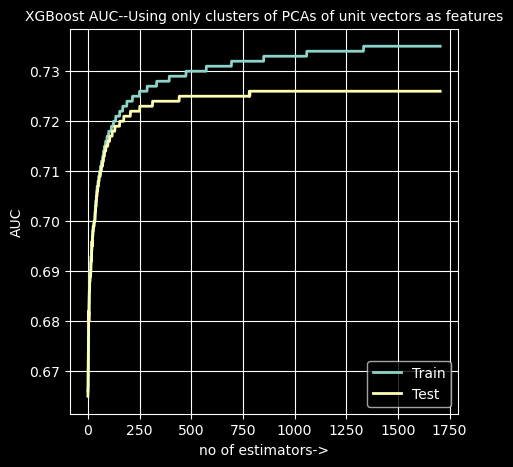

In [ ]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

### Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [ ]:
# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = avazuunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

SyntaxError: invalid syntax (3228214416.py, line 18)

## Analysing Graphs
Deriving features directly from graphs


In [ ]:
# 21.0 Path where .gml files are placed:

pathToFolder = avazugraphs
filelist = sorted(list(pathToFolder.iterdir()))
filelist[5:10]   # mgrid_bigraph_*


[WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cfourteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cnineteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cone.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cseventeen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Csixteen.gml')]

### Read back data files

In [ ]:
# 21.1 Just to recapitulate:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)
y_train.shape       #
test_trans.shape    # (499831, 591)
y_test.shape        #

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_id', 'device_id']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1499493, 576)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

#
gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,1624,104,4,3356,1,...,0.086143,0.694915,0.141788,0.016860,0.508475,0.175684,0.022399,0.966102,0.144482,0.020157
1,1005,0,1610,2741,5,2110,30,4,4138,1,...,-0.005279,0.711864,0.142679,0.017328,0.288136,0.084613,0.015599,0.847458,0.137510,0.017518


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,2198,209,4,1012,1,...,0.074523,1.000000,0.165342,0.024729,0.796610,0.206639,0.037151,0.847458,0.136972,0.017598
1,1005,1,271,192,22,3617,110,0,4213,1,...,-0.027320,0.694915,0.141788,0.016860,0.050847,0.010373,0.005809,0.881356,0.139722,0.018241


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,1624,104,4,19447,744774,...,50,2507,0,35,-1,157,10,2,22,13
1,1005,0,1610,2741,5,2110,30,4,268552,187878,...,50,2681,1,419,100084,212,10,3,30,8


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,2198,209,4,184577,264759,...,50,1996,1,41,100057,71,10,3,23,13
1,1005,1,271,192,22,3617,110,0,184577,65793,...,50,2371,0,559,100217,46,10,1,28,23


(1499493, 591)

(1499493,)

(499831, 591)

(499831,)

(1499493, 576)

(499831, 576)

CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath=WindowsPath('D:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/avazu/allmodels'),
                  saveGraph=True)

0

In [ ]:
# 22.0 Get sample list of projected and bigraphs:

projected = [str(i).split("\\")[-1] for i in filelist if 'appcategory_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'appcategory_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['appcategory_bigraph_Cone.gml',
 'appcategory_bigraph_appid.gml',
 'appcategory_bigraph_siteid.gml',
 'appcategory_bigraph_Ctwenty.gml',
 'appcategory_bigraph_Cfifteen.gml',
 'appcategory_bigraph_Csixteen.gml',
 'appcategory_bigraph_appdomain.gml',
 'appcategory_bigraph_bannerpos.gml']



====



['appcategory_projected_Cone.gml',
 'appcategory_projected_appid.gml',
 'appcategory_projected_siteid.gml',
 'appcategory_projected_Ctwenty.gml',
 'appcategory_projected_Cfifteen.gml',
 'appcategory_projected_Csixteen.gml',
 'appcategory_projected_appdomain.gml',
 'appcategory_projected_bannerpos.gml']

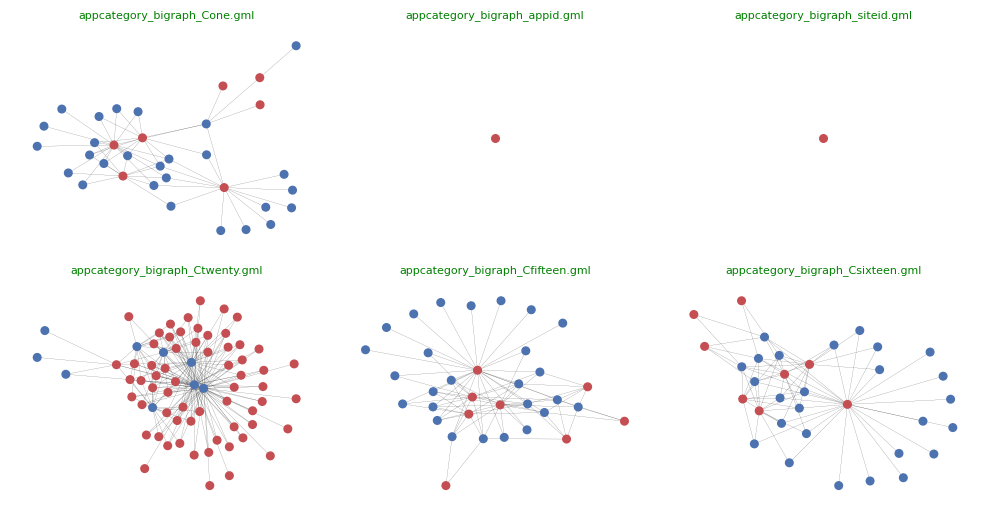

In [ ]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 avazugraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

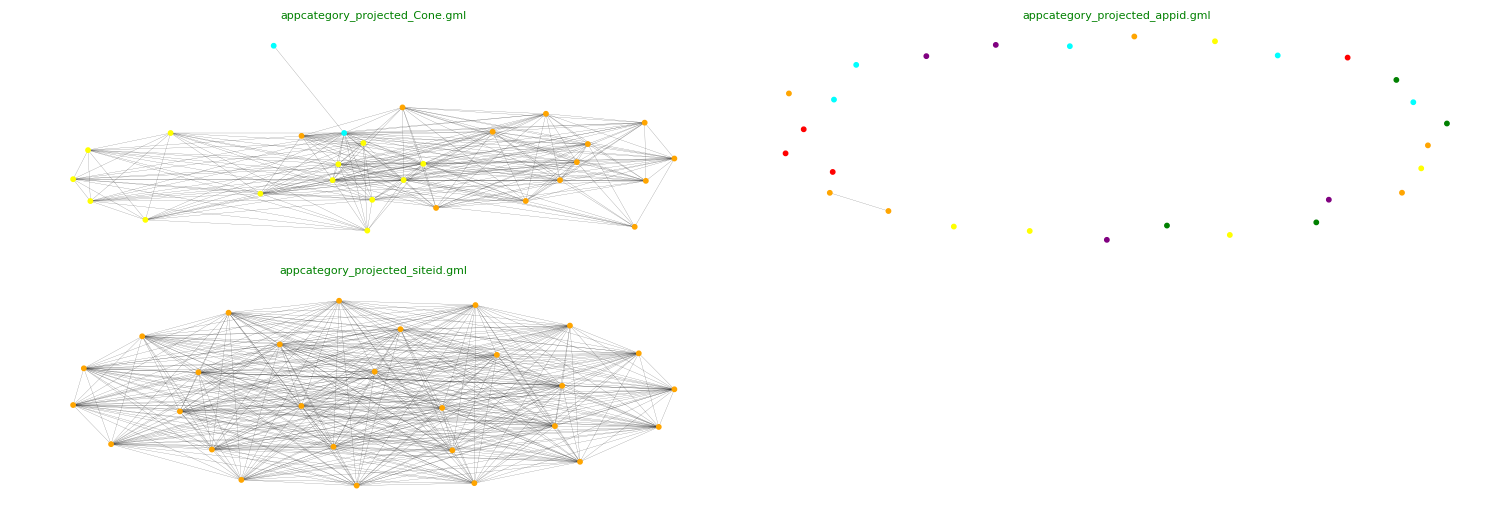

In [ ]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   avazugraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [ ]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#pathToGraphFolder= Path("D:\\avazu\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  siteid_projected_Cone.gml
Reading file:  siteid_projected_bannerpos.gml
Reading file:  siteid_projected_sitedomain.gml
Reading file:  siteid_projected_sitecategory.gml
Reading file:  siteid_projected_appid.gml
Reading file:  siteid_projected_appdomain.gml
Reading file:  siteid_projected_appcategory.gml
Reading file:  siteid_projected_devicemodel.gml
Reading file:  siteid_projected_devicetype.gml
Reading file:  siteid_projected_deviceconntype.gml
Reading file:  siteid_projected_Cfourteen.gml
Reading file:  siteid_projected_Cfifteen.gml
Reading file:  siteid_projected_Csixteen.gml
Reading file:  siteid_projected_Cseventeen.gml
Reading file:  siteid_projected_Ceighteen.gml
Reading file:  siteid_projected_Cnineteen.gml
Reading file:  siteid_projected_Ctwenty.gml
Reading file:  siteid_projected_Ctwentyone.gml
Reading file:  sitedomain_projected_Cone.gml
Reading file:  sitedomain_projected_bannerpos.gml
Reading file:  sitedomain_projected_siteid

In [ ]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (1501119, 212)/(1499493, 212)
print("\n--\n")
fg_te[0].shape   # (500374, 212)/(499831, 212)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(1499493, 212)


--



(499831, 212)


--



,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0
1,1.0,1.0,1110.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,1,0,0,0,0,0,0


In [ ]:
# 24.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (1499493, 212)
Datashape after processing: (1499493, 161)


In [ ]:
# 24.2 Save the list to gdrive:

utils.savePythonObject(fg_tr, "fg_tr.pkl", avazudata)
utils.savePythonObject(fg_te, "fg_te.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\fg_tr.pkl
Object saved to: D:\avazu\allmodels\datafiles\fg_te.pkl


In [ ]:
# 24.3

fg_tr = utils.restorePythonObject( "fg_tr.pkl", avazudata )
fg_te = utils.restorePythonObject( "fg_te.pkl", avazudata )
fg_tr[0].shape  # (1501119, 161)/(1499493, 161)
fg_te[0].shape  # (500374, 161)/(499831, 161)

(1499493, 161)

(499831, 161)

In [ ]:
# 24.4 Check restoration:

fg_tr[0].head(2)
fg_te[0].head(2)

,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,1,0,0
1,1.0,1.0,1110.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,0,1,1,0,0,0,0


## xgboost modeling with data transformed through community classes

In [ ]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 13,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[13:05:34] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:05:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4044 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73636	validation_1-auc:0.73064
[13:05:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3798 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73914	validation_1-auc:0.73256
[13:05:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3880 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.74059	validation_1-auc:0.73384
[13:05:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3830 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.74183	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Save model object:

utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_trans_commu.pkl


In [ ]:
# Restore model object:

model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", avazudata)

### Learning curve

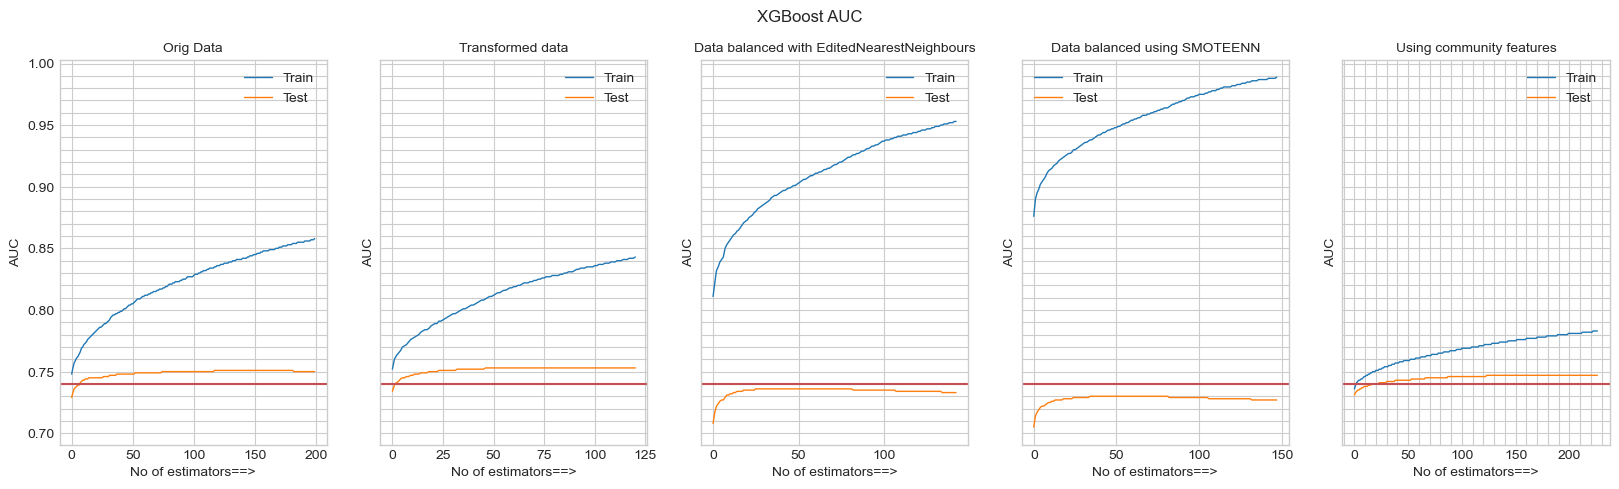

In [ ]:
# 19.3 Learning curves: xgboost modeling"

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,5, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result(), model_trans_commu.evals_result()]
title = ["Orig Data", "Transformed data", "Data balanced with EditedNearestNeighbours", 'Data balanced using SMOTEENN',"Using community features" ]
fig.suptitle("XGBoost AUC")
for i in range(5):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y=0.74, color='r', linestyle='-')

plt.show();

#### Classification report

In [ ]:
# 25.2 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")


Classification report from community data: 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.60      0.08      0.15     84744

    accuracy                           0.84    499831
   macro avg       0.72      0.54      0.53    499831
weighted avg       0.80      0.84      0.78    499831



In [ ]:
############# Done ###############

## ROUGH WORK

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'device_id',  'device_ip']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazufolder)
ct

#
gc.collect()

In [ ]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazufolder) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.849631,-0.462719,0.560084,0.103338,-0.274097,-0.368581,-0.839830,0.391659,-0.459640,0.165295,...,-0.235170,0.191174,0.061168,1.091684,-0.014206,0.195178,-0.525828,0.365271,-0.450755,0.633413
1,1.155139,0.278564,0.410264,-1.244982,0.711136,2.161509,1.152552,-0.602603,1.328864,-1.608991,...,7.061366,-0.712683,0.027135,-0.952509,3.091211,1.870719,-0.473455,-3.947109,3.381505,1.684289
2,-0.679183,-0.699284,-0.083493,0.025313,-0.233486,0.085268,-0.849323,0.032845,-0.439538,0.117099,...,0.224154,-0.034428,0.339811,0.868301,-0.223116,-1.030807,-0.455839,0.140223,-0.364641,0.703816


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.771130,-0.453043,0.095163,0.557658,-0.344208,-0.033671,-0.710520,0.435808,-0.115957,1.102022,...,0.177579,-0.462857,-0.303582,-0.536073,-0.035448,-0.485754,-0.589400,0.886848,-0.017880,-0.268141
1,-0.752837,-0.339575,0.088783,-1.141025,-0.199802,0.185162,0.043599,0.124799,-1.227015,0.896823,...,-0.518168,-0.111798,0.725304,-0.462391,-0.174001,-0.462952,1.012376,-1.013665,-0.281133,-0.180926
2,-0.827908,-0.954810,-0.000639,-0.099604,0.415293,-0.110808,0.136972,-0.378553,-1.093366,0.855857,...,-0.710794,0.551108,0.100063,0.058558,-0.215256,-0.200750,0.266654,-0.267910,0.074544,0.263067


In [ ]:
from imblearn.under_sampling import InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, NeighbourhoodCleaningRule,OneSidedSelection
from imblearn.combine import SMOTEENN

In [ ]:
inst = InstanceHardnessThreshold()
start = time.time()
X_res, y_res = inst.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


In [ ]:
X_res.shape  # (548699, 97)
y_res.shape  # (548699,)

(548699, 97)

(548699,)

In [ ]:

model_km = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  pca_test
ytrain =  y_res
ytest = y_test


model_km.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[15:00:36] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:00:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3780 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.93528	validation_1-auc:0.69267
[15:00:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3834 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.94281	validation_1-auc:0.69800
[15:00:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3868 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.94824	validation_1-auc:0.70308
[15:00:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4184 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.95010	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 24.3 Classification report:

pred_km = model_km.predict(test_X)
print(classification_report(ytest,pred_km))


              precision    recall  f1-score   support

           0       0.94      0.41      0.58    414878
           1       0.23      0.88      0.37     84806

    accuracy                           0.49    499684
   macro avg       0.59      0.65      0.47    499684
weighted avg       0.82      0.49      0.54    499684



In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_km.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_test, pred_km, labels=model_km.classes_)

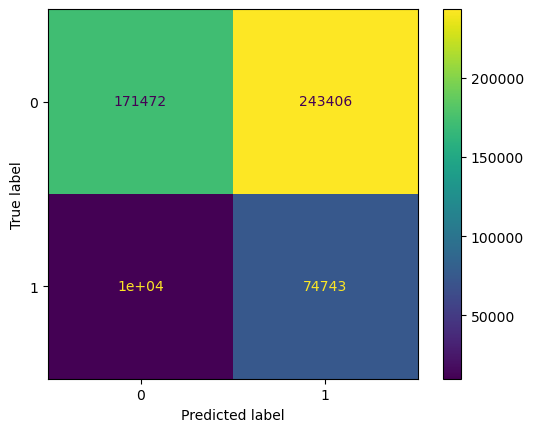

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_km.classes_)
disp.plot()

In [ ]:
ncr = NeighbourhoodCleaningRule()
start = time.time()
X_res_ncr, y_res_ncr = ncr.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


35.54191811879476


In [ ]:
X_res_ncr.shape  # (1086165, 97)
y_res_ncr.shape  # (1086165, )

(1086165, 97)

(1086165,)

In [ ]:

model_ncr = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res_ncr
test_X =  pca_test
ytrain =  y_res_ncr
ytest = y_test


model_ncr.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[05:24:44] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:24:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4136 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.78990	validation_1-auc:0.70346
[05:24:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3772 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.80119	validation_1-auc:0.71216
[05:24:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4058 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.80691	validation_1-auc:0.71571
[05:25:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4020 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.81086	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_ncr.best_score  # 0.73726971

0.7372697120689804

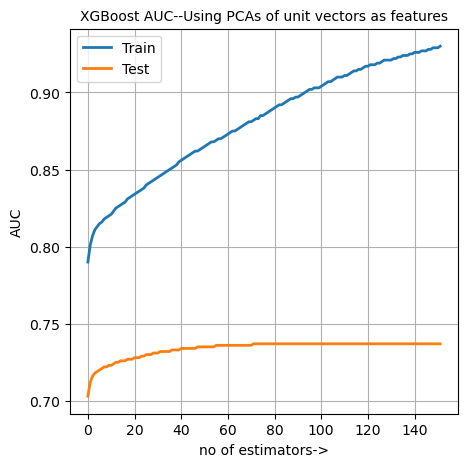

In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_ncr.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [ ]:
# 24.3 Classification report:

pred_ncr = model_ncr.predict(test_X)
print(classification_report(ytest,pred_ncr))


              precision    recall  f1-score   support

           0       0.87      0.88      0.87    414878
           1       0.37      0.35      0.36     84806

    accuracy                           0.79    499684
   macro avg       0.62      0.61      0.62    499684
weighted avg       0.78      0.79      0.79    499684



In [ ]:
####################